In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import warnings
import importlib 
import plsda_module

import plot_ap1
import plotly.express as px
import io
import matplotlib as mpl
from scipy.stats import randint, uniform
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
plt.rcParams['xtick.labelsize'] = 22 # or whatever size you want
plt.rcParams['ytick.labelsize'] = 22 # or whatever size you want

# Set global font size for labels, titles and legends
plt.rcParams['axes.labelsize'] = 20# or whatever size you want
plt.rcParams['axes.titlesize'] = 20 # or whatever size you want
plt.rcParams['legend.fontsize'] = 16 # or whatever size you want
#plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
folder_path = "/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/processed_simulations/updated_cell_specific_simulations/"
cell = 'LOXIMVI'
version = "V4"

data_file = f"{cell}_cell_specific_parameter_initialcondition_and_steadystates_{version}.csv"
dat = pd.read_csv(os.path.join(folder_path, data_file))


In [5]:
importlib.reload(plsda_module)
from plsda_module import PLSDA

importlib.reload(plot_ap1)
from plot_ap1 import plot_parameter_distributions, plot_2d_scatter,plot_3d_scatter_subplots,plot_3d_density,plot_2d_density_projections



In [6]:
def rename_columns(df):
    new_column_names = {}
    
    def convert_protein_names(text):
        """Convert protein names - order is critical!"""
        # Do longer/more specific names first to avoid partial matches
        text = text.replace('jund', 'JUND')  # Do jund before jun
        text = text.replace('fra2', 'FRA2')  # Do fra2 before fra1
        text = text.replace('fra1', 'FRA1')
        text = text.replace('jun', 'cJUN')   # Do jun after jund
        text = text.replace('fos', 'cFOS')
        return text
    
    for col in df.columns:
        # For basal columns: replace with α (alpha) and add underscore
        if 'basal' in col:
            protein = re.search(r'basal_(\w+)', col).group(1)
            converted_protein = convert_protein_names(protein)
            new_column_names[col] = f"α_{converted_protein}"
        
        # For degradation columns: replace with γ (gamma) and add underscore
        elif 'degradation' in col:
            protein = re.search(r'degradation_(\w+)', col).group(1)
            converted_protein = convert_protein_names(protein)
            new_column_names[col] = f"γ_{converted_protein}"
        
        # For beta columns: replace with β (beta) and add underscore
        elif '.beta' in col:
            interaction = re.search(r'\((.*?)\)\.beta', col).group(1)
            converted_interaction = convert_protein_names(interaction)
            new_column_names[col] = f"β_{converted_interaction}"
        
        # Keep any other columns as is (like 'interest_class')
        else:
            new_column_names[col] = col
    
    return df.rename(columns=new_column_names)

### Figure 5 (B-C)Modeling separation between monostable and bistable states
##### Question: What features in our parameter space separate monostable and bistable states?

In [7]:
dat_1 = dat.copy()
cols_to_remove = ['init_cond_index', 'state', 'fos', 'jun', 'fra1', 'fra2', 'jund','fos_ss','jun_ss','fra1_ss','fra2_ss','jund_ss']
dat_1.drop(cols_to_remove, axis=1, inplace=True)

# drop duplicate param_index
dat_1.drop_duplicates(subset='param_index', inplace=True)

# drop param_index
dat_1.drop('param_index', axis=1, inplace=True)

dat_1

interest_states = ['bi_stable']

dat_1['interest_class'] = np.where(dat_1['unique_steady_states'].isin(interest_states), 1, 0)

# drop the unique_steady_states column
dat_1.drop('unique_steady_states', axis=1, inplace=True)
dat_1

(basal_fos).v  (basal_jun).v  (basal_fra1).v  (basal_fra2).v  \
0             3.51348        6.23938         2.75645         1.17920   
150           4.83183        5.65293         0.17113         2.54778   
300           0.69610        7.51703         0.17390         0.66903   
450           0.72296        6.10969         2.91160         1.25732   
600           8.60226        6.19385         0.17837         0.44547   
...               ...            ...             ...             ...   
192737        2.37300        6.35660         0.17751         1.83279   
192887        1.18747        7.88670         0.14613         0.36399   
192937        1.02638        6.21016         3.21132         2.35344   
193087        7.29294        0.14510         0.14453         1.54536   
193181        0.35969        7.43597         1.26553         0.30424   

        (basal_jund).v  (jun_by_junjun).beta  (jun_by_junfos).beta  \
0              5.03680              20.58021               5.81476   
150            7.01086              58.12772              31.97274   
300            2.47411               8.79305             169.28631   
450            5.29329              28.86403              37.24679   
600            4.28368               3.06599               4.38193   
...                ...                   ...                   ...   
192737         2.32691             192.29424               3.42321   
192887         4.30143              18.62674             102.69864   
192937         6.45143              67.53010               3.29546   
193087         7.27952              21.59967             139.56446   
193181         4.96410              11.85786              76.53874   

        (fra1_by_junfra1).beta  (fra1_by_jundfos).beta  \
0                     78.26636                21.73407   
150                   37.20289               102.96200   
300                   20.96384               143.84768   
450                   53.37406                20.63374   
600                  121.09712                47.92727   
...                        ...                     ...   
192737               128.57895               110.00358   
192887                73.89681                 2.36649   
192937                32.27748                77.10979   
193087                10.31931                66.98887   
193181                98.09277                 8.79380   

        (fra2_by_junfra2).beta  (degradation_fos).k1  (degradation_jun).k1  \
0                     17.17804               0.53332               0.73908   
150                   35.56151               1.53200               0.49401   
300                    2.97708               0.91342               0.76951   
450                   32.33980               0.51991               0.52255   
600                    6.25562               0.93905               0.57594   
...                        ...                   ...                   ...   
192737                26.59985               0.77317               1.15439   
192887                42.23103               0.78702               0.85766   
192937                44.00157               1.02830               1.11156   
193087                 4.13817               0.84657               0.54762   
193181                 3.29799               0.73360               0.51040   

        (degradation_fra1).k1  (degradation_fra2).k1  (degradation_jund).k1  \
0                     0.30491                0.10016                0.08571   
150                   0.31378                0.11460                0.13307   
300                   0.33246                0.08788                0.06786   
450                   0.54039                0.12717                0.14071   
600                   0.54014                0.09317                0.07512   
...                       ...                    ...                    ...   
192737                0.46146                0.20406                0.11004   
192887                0.30010       

In [8]:

# Apply the renaming to your existing subset_data
# This will create a new dataframe with renamed columns, preserving all your data
renamed_df = rename_columns(dat_1.copy())

In [10]:
renamed_df

α_cFOS   α_cJUN   α_FRA1   α_FRA2   α_JUND  β_cJUN_by_cJUNcJUN  \
0       3.51348  6.23938  2.75645  1.17920  5.03680            20.58021   
150     4.83183  5.65293  0.17113  2.54778  7.01086            58.12772   
300     0.69610  7.51703  0.17390  0.66903  2.47411             8.79305   
450     0.72296  6.10969  2.91160  1.25732  5.29329            28.86403   
600     8.60226  6.19385  0.17837  0.44547  4.28368             3.06599   
...         ...      ...      ...      ...      ...                 ...   
192737  2.37300  6.35660  0.17751  1.83279  2.32691           192.29424   
192887  1.18747  7.88670  0.14613  0.36399  4.30143            18.62674   
192937  1.02638  6.21016  3.21132  2.35344  6.45143            67.53010   
193087  7.29294  0.14510  0.14453  1.54536  7.27952            21.59967   
193181  0.35969  7.43597  1.26553  0.30424  4.96410            11.85786   

        β_cJUN_by_cJUNcFOS  β_FRA1_by_cJUNFRA1  β_FRA1_by_JUNDcFOS  \
0                  5.81476            78.26636            21.73407   
150               31.97274            37.20289           102.96200   
300              169.28631            20.96384           143.84768   
450               37.24679            53.37406            20.63374   
600                4.38193           121.09712            47.92727   
...                    ...                 ...                 ...   
192737             3.42321           128.57895           110.00358   
192887           102.69864            73.89681             2.36649   
192937             3.29546            32.27748            77.10979   
193087           139.56446            10.31931            66.98887   
193181            76.53874            98.09277             8.79380   

        β_FRA2_by_cJUNFRA2   γ_cFOS   γ_cJUN   γ_FRA1   γ_FRA2   γ_JUND  \
0                 17.17804  0.53332  0.73908  0.30491  0.10016  0.08571   
150               35.56151  1.53200  0.49401  0.31378  0.11460  0.13307   
300                2.97708  0.91342  0.76951  0.33246  0.08788  0.06786   
450               32.33980  0.51991  0.52255  0.54039  0.12717  0.14071   
600                6.25562  0.93905  0.57594  0.54014  0.09317  0.07512   
...                    ...      ...      ...      ...      ...      ...   
192737            26.59985  0.77317  1.15439  0.46146  0.20406  0.11004   
192887            42.23103  0.78702  0.85766  0.30010  0.11151  0.16108   
192937            44.00157  1.02830  1.11156  0.31652  0.11765  0.13490   
193087             4.13817  0.84657  0.54762  0.68252  0.30267  0.10912   
193181             3.29799  0.73360  0.51040  0.66733  0.10636  0.14381   

        interest_class  
0                    0  
150                  0  
300                  0  
450                  0  
600                  0  
...                ...  
192737               0  
192887               0  
192937               0  
193087               0  
193181               0  

[1399 rows x 16 columns]

/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: 

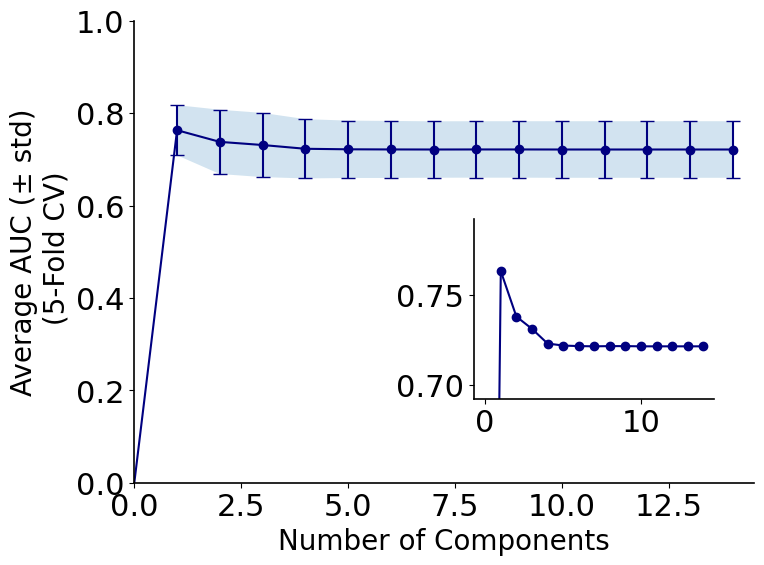

Maximum AUC at components: 1
Diminishing returns at components: 1
Maximum mean AUC: 0.763 ± 0.054
AUC at diminishing returns: 0.763 ± 0.054
Recommended number of components: 1
Optimal number of components: 1
Component 1:
Cumulative Y variance: 29.53%
Incremental Y variance: 29.53%
Component 2:
Cumulative Y variance: 32.50%
Incremental Y variance: 2.97%


In [17]:
X = renamed_df.drop(columns = ['interest_class'])
y = renamed_df['interest_class']

# keep one hot encoding as False
plsda = PLSDA(n_components=None, cv_folds=5, one_hot_encode=False, downsample_ratio= 3)

# Determine the optimal number of components
optimal_components, mean_scores = plsda.find_optimal_components(X, y, max_components=14,save_plot=False)
print(f'Optimal number of components: {optimal_components}')

# Fit and transform the data using the optimal number of components
plsda.n_components = 2
X_pls, x_var,y_var, y_encoded, X_downsampled, y_balanced = plsda.fit_transform(X, y)

class_descriptions = {0: 'mono_stable', 1: 'bi_stable'}
# plot_scores = plsda.plot_scores_with_density(X_pls, x_var,y_var, y_encoded, lv1 = 0, lv2 = 1, class_descriptions=class_descriptions, colors = ['#BCB8B1','#07BEB8'],
#                   alpha_values = [0.7, 1],line_colors = ['w','k'], save_plot=True)


In [ ]:
# Perform cross-validation and plot ROC curve

# y_scores, y_encoded = plsda.cross_validation(X, y)
# #plsda.plot_roc(y_scores, y_encoded)
# plsda.plot_mean_roc(X, y, save_plot=False)
# plsda.plot_mean_roc(X, y, save_plot=False)


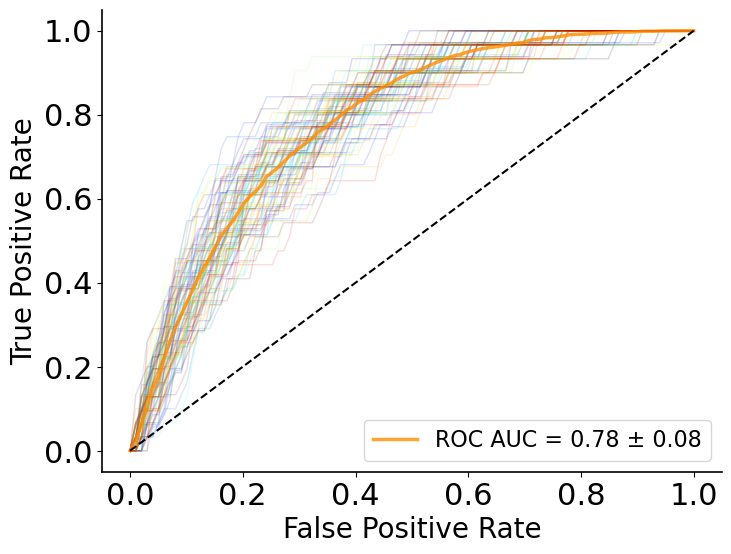

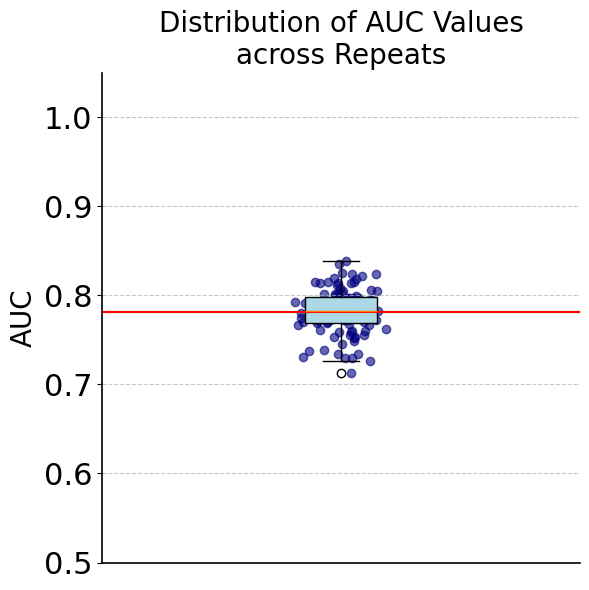

Repeated CV Results (100 repeats):
Mean AUC: 0.782 ± 0.026
Range: [0.713, 0.839]
Repeated cross-validation AUC: 0.782 ± 0.026


In [ ]:
mean_auc, std_auc = plsda.repeated_cv_with_visualization(
    X, y, n_repeats=1000, save_plot=True, show_individual_curves=True
)
print(f"Repeated cross-validation AUC: {mean_auc:.3f} ± {std_auc:.3f}")

In [ ]:
# vip_scores = plsda.compute_vip()
# signed_vip_scores, feature_names = plsda.compute_signed_vip(X,y,X.columns)
# # save figure as pdf

# plsda.plot_signed_vip(signed_vip_scores, feature_names, save_plot=False, colors=['#BCB8B1','#07BEB8'])


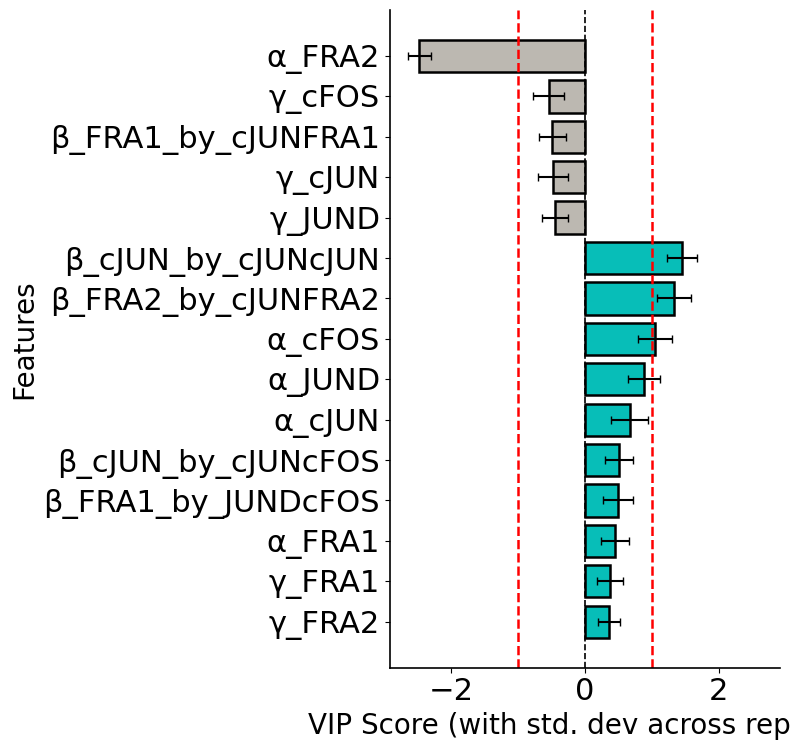

In [ ]:
mean_vips, std_vips, feature_names = plsda.plot_repeated_vip(
    X, y, n_repeats=1000, save_plot=True, colors=['#BCB8B1','#07BEB8']
)

In [ ]:
# extracting the downsampled data
# Assuming X_downsampled and y_balanced are numpy arrays
if isinstance(X_downsampled, np.ndarray) and isinstance(y_balanced, np.ndarray):
    # Create a DataFrame from X_downsampled
    feature_columns = dat_1.drop(columns=['interest_class']).columns
    downsampled_df = pd.DataFrame(X_downsampled, columns=feature_columns)
    
    # Add the y_balanced as a new column
    downsampled_df['interest_class'] = y_balanced

# If X_downsampled and y_balanced are already pandas DataFrame/Series
elif isinstance(X_downsampled, pd.DataFrame) and isinstance(y_balanced, (pd.Series, pd.DataFrame)):
    # Ensure column names match dat_1
    X_downsampled.columns = dat_1.drop(columns=['interest_class']).columns
    
    # Concatenate
    downsampled_df = pd.concat([X_downsampled, y_balanced.rename('interest_class')], axis=1)

# Ensure the column order matches dat_1
downsampled_df = downsampled_df[dat_1.columns]
# rename interest_class column to 'bi_stable' if interest_class is 1
downsampled_df['interest_class'] = downsampled_df['interest_class'].map({0: 'mono_stable', 1: 'bi_stable'})

dat_1_copy = dat_1.copy()
# Update the interest_class column
dat_1_copy['interest_class'] = dat_1_copy['interest_class'].map({0: 'mono_stable', 1: 'bi_stable'})


In [21]:
# if interest_class is 1, then rename the interest_class column to 'bi_stable' else 'mono_stable'
renamed_df['interest_class'] = renamed_df['interest_class'].map({1: 'bi_stable', 0: 'mono_stable'})


In [22]:
renamed_df

α_cFOS   α_cJUN   α_FRA1   α_FRA2   α_JUND  β_cJUN_by_cJUNcJUN  \
0       3.51348  6.23938  2.75645  1.17920  5.03680            20.58021   
150     4.83183  5.65293  0.17113  2.54778  7.01086            58.12772   
300     0.69610  7.51703  0.17390  0.66903  2.47411             8.79305   
450     0.72296  6.10969  2.91160  1.25732  5.29329            28.86403   
600     8.60226  6.19385  0.17837  0.44547  4.28368             3.06599   
...         ...      ...      ...      ...      ...                 ...   
192737  2.37300  6.35660  0.17751  1.83279  2.32691           192.29424   
192887  1.18747  7.88670  0.14613  0.36399  4.30143            18.62674   
192937  1.02638  6.21016  3.21132  2.35344  6.45143            67.53010   
193087  7.29294  0.14510  0.14453  1.54536  7.27952            21.59967   
193181  0.35969  7.43597  1.26553  0.30424  4.96410            11.85786   

        β_cJUN_by_cJUNcFOS  β_FRA1_by_cJUNFRA1  β_FRA1_by_JUNDcFOS  \
0                  5.81476            78.26636            21.73407   
150               31.97274            37.20289           102.96200   
300              169.28631            20.96384           143.84768   
450               37.24679            53.37406            20.63374   
600                4.38193           121.09712            47.92727   
...                    ...                 ...                 ...   
192737             3.42321           128.57895           110.00358   
192887           102.69864            73.89681             2.36649   
192937             3.29546            32.27748            77.10979   
193087           139.56446            10.31931            66.98887   
193181            76.53874            98.09277             8.79380   

        β_FRA2_by_cJUNFRA2   γ_cFOS   γ_cJUN   γ_FRA1   γ_FRA2   γ_JUND  \
0                 17.17804  0.53332  0.73908  0.30491  0.10016  0.08571   
150               35.56151  1.53200  0.49401  0.31378  0.11460  0.13307   
300                2.97708  0.91342  0.76951  0.33246  0.08788  0.06786   
450               32.33980  0.51991  0.52255  0.54039  0.12717  0.14071   
600                6.25562  0.93905  0.57594  0.54014  0.09317  0.07512   
...                    ...      ...      ...      ...      ...      ...   
192737            26.59985  0.77317  1.15439  0.46146  0.20406  0.11004   
192887            42.23103  0.78702  0.85766  0.30010  0.11151  0.16108   
192937            44.00157  1.02830  1.11156  0.31652  0.11765  0.13490   
193087             4.13817  0.84657  0.54762  0.68252  0.30267  0.10912   
193181             3.29799  0.73360  0.51040  0.66733  0.10636  0.14381   

       interest_class  
0         mono_stable  
150       mono_stable  
300       mono_stable  
450       mono_stable  
600       mono_stable  
...               ...  
192737    mono_stable  
192887    mono_stable  
192937    mono_stable  
193087    mono_stable  
193181    mono_stable  

[1399 rows x 16 columns]

In [23]:
importlib.reload(plot_ap1)
from plot_ap1 import plot_parameter_distributions, plot_2d_scatter,plot_3d_scatter_subplots,plot_3d_density,plot_2d_density_projections


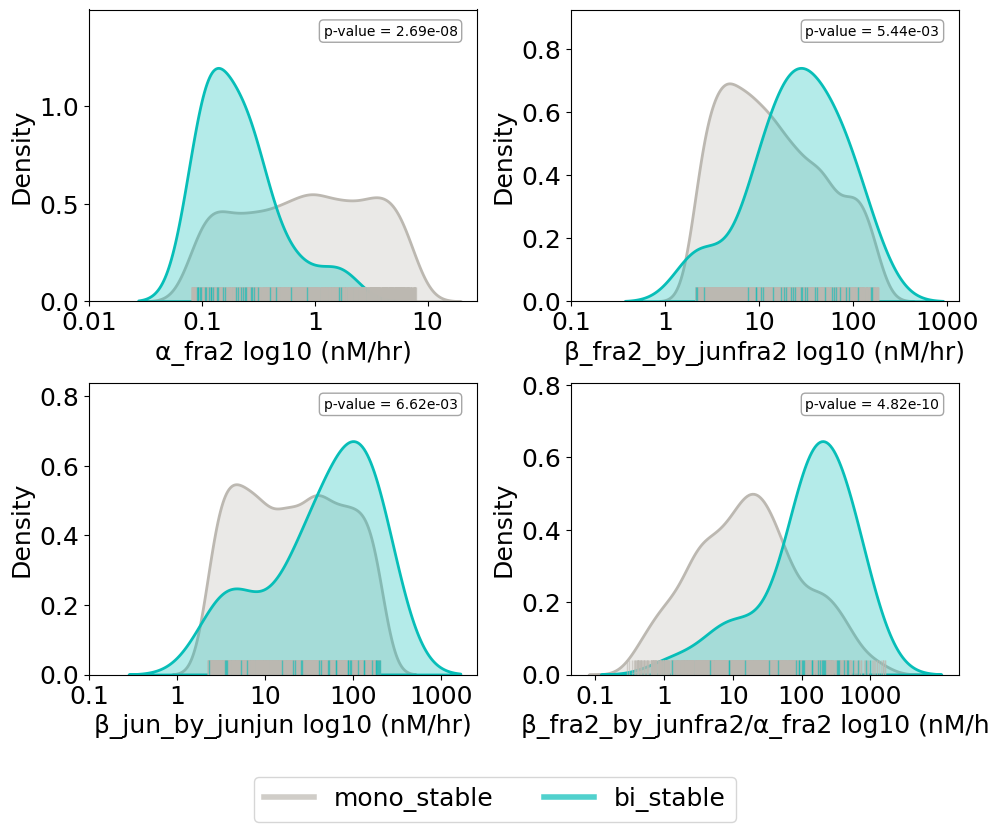

In [37]:
# plot distribution of fra2 for the high and low fra2 states
par_names = ['α_fra2', 'β_fra2_by_junfra2', 'β_jun_by_junjun', 'β_fra2_by_junfra2/α_fra2']
fig = plot_ap1.plot_parameter_distributions(renamed_df, par_names, 'interest_class', 
                                      color_palette={'mono_stable': '#BCB8B1', 'bi_stable': '#07BEB8'}, 
                                      ncols=2, figsize=(10, 8), stat_test='ks_test',
                                     output_filename=f'multistable_{cell}_distribution_with_fra2_ratio.pdf')

In [ ]:
# plot 3d scatter
fig = plot_ap1.plot_3d_scatter(renamed_df, 'α_fra2', 'β_fra2_by_junfra2','β_jun_by_junjun', 
                               interest_class_labels=['mono_stable', 'bi_stable'],
                               color_map={'mono_stable': '#BCB8B1', 'bi_stable': '#07BEB8'},
                               opacity_map={'mono_stable': 0.4, 'bi_stable': 1.0},
                               size_map={'mono_stable': 10, 'bi_stable': 20})
# fig.update_layout(scene_camera=dict(eye=dict(x=1.25, y=1.25, z=0.5),
#                                     up=dict(x=0, y=0, z=1),
#                                     center=dict(x=.2, y=.2, z=.2)))
#fig.write_image("high_res_plot.pdf", format='pdf', scale=2, width=1400, height=1400,engine='kaleido')

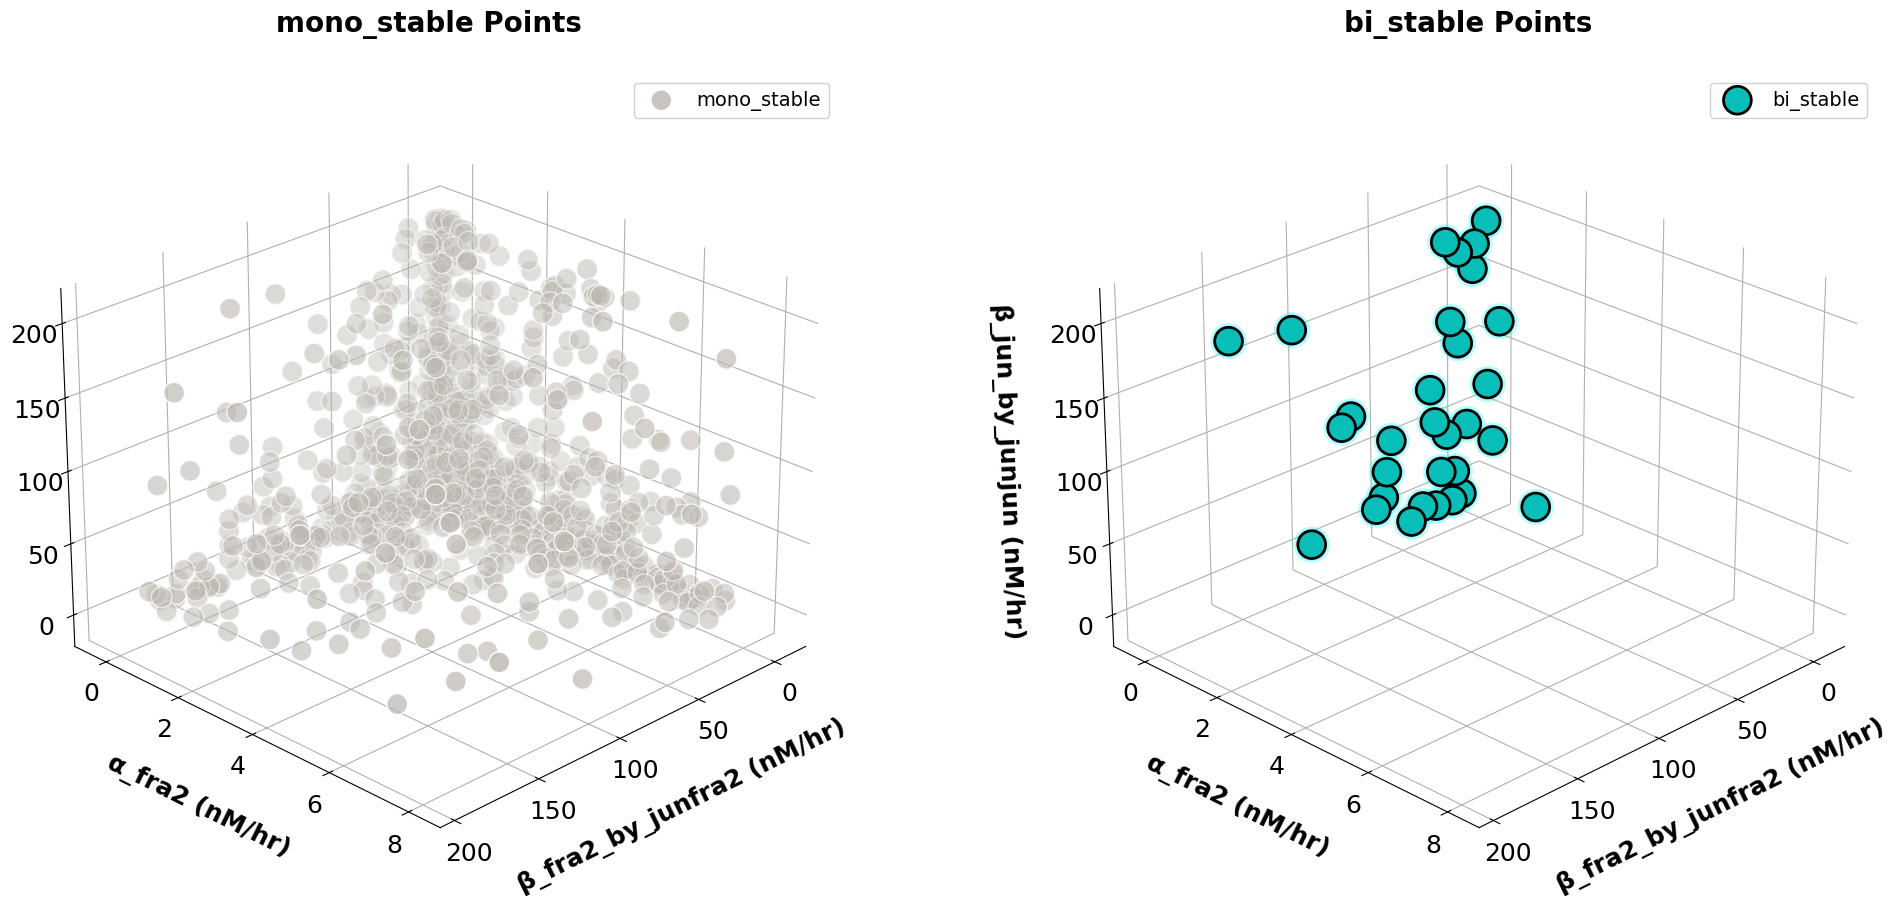

In [ ]:
# Plot
fig, ax = plot_3d_scatter_subplots(
    renamed_df, 
    'β_FRA2_by_JUNFRA2','α_FRA2','β_cJUN_by_cJUNcJUN',
    color_map={'bi_stable': '#07BEB8','mono_stable': '#BCB8B1'},
    opacity_map={'bi_stable': 1.0,'mono_stable': 0.8},
    size_map={'bi_stable': 20,'mono_stable': 15},
    edge_color_map={'bi_stable': 'black','mono_stable': 'white'},
    output_filename=f'multistable_{cell}_3d_scatter_fra2.pdf'
)

In [24]:
# print the columns of renamed_df
print(renamed_df.columns)

Index(['α_cFOS', 'α_cJUN', 'α_FRA1', 'α_FRA2', 'α_JUND', 'β_cJUN_by_cJUNcJUN',
       'β_cJUN_by_cJUNcFOS', 'β_FRA1_by_cJUNFRA1', 'β_FRA1_by_JUNDcFOS',
       'β_FRA2_by_cJUNFRA2', 'γ_cFOS', 'γ_cJUN', 'γ_FRA1', 'γ_FRA2', 'γ_JUND',
       'interest_class'],
      dtype='object')


In [12]:
# add a column that is the ratio of β_fra2_by_junfra2 and α_fra2
renamed_df['β_fra2_by_junfra2/α_fra2'] = renamed_df['β_fra2_by_junfra2'] / renamed_df['α_fra2']


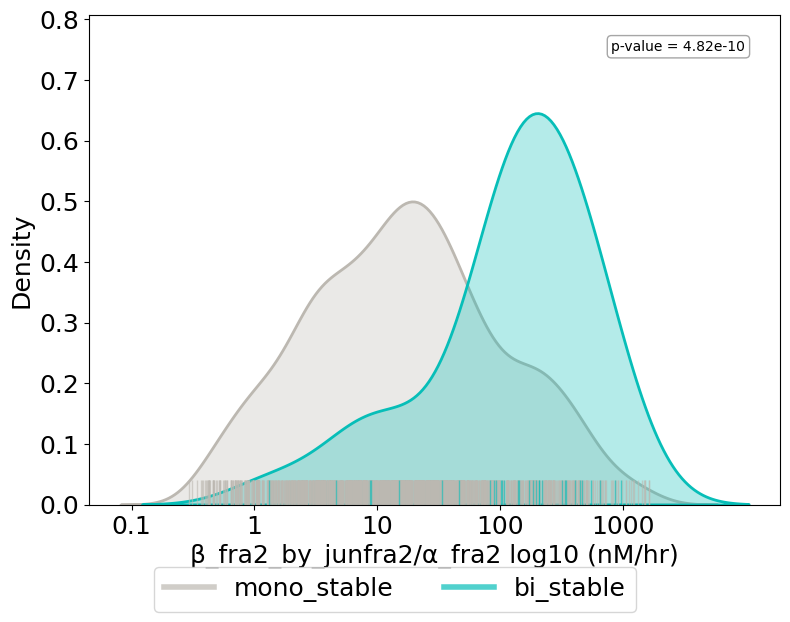

In [16]:
par_names = ['β_fra2_by_junfra2/α_fra2']
fig = plot_ap1.plot_parameter_distributions(renamed_df, par_names, 'interest_class', 
                                      color_palette={'mono_stable': '#BCB8B1', 'bi_stable': '#07BEB8'}, 
                                      ncols=1, figsize=(8, 6), stat_test='ks_test',
                                     output_filename=f'multistable_{cell}_fra2_ratio_distribution.pdf')

In [ ]:
# fig = plot_ap1.plot_2d_scatter(
#     data=renamed_df, 
#     x_param='α_fra2', 
#     y_param='β_fra2_by_junfra2',
#     class_column='interest_class',  # This specifies which column contains the classes
#     class_labels=['mono_stable', 'bi_stable'],           # This specifies the actual class labels
#     colors=['#BCB8B1', '#07BEB8'],
#     markers=['o', 'o'],
#     alpha_values=[0.3, 1],
#     figsize=(10, 6),
#     sizes=[50, 150],
#     ylim=[1.5,200],
#     xlim=[0,10],
#     log_scale=True,
#     edgecolors=['k', 'k'],
#     output_filename=f'multistable_{cell}_2d_scatter_fra2.pdf'
   
# )

#### Figure 5C Plot mono and bi stable with high or low outcomes

In [32]:
dat2 = dat.copy()
cols_to_remove = ['fos', 'jun', 'fra1', 'fra2', 'jund',]
dat2.drop(cols_to_remove, axis=1, inplace=True)

# drop duplicate based on param_index, init_cond_index, unique_steady_states,fos_ss,jun_ss,fra1_ss,fra2_ss,jund_ss
dat2.drop_duplicates(subset=['param_index','unique_steady_states','state'], inplace=True)

# keep the columns (basal_fra2).v, (fra2_by_junfra2).beta, unique_steady_states,fra2_ss
dat2 = dat2[['param_index', '(basal_fra2).v', '(fra2_by_junfra2).beta', 'unique_steady_states', 'fra2_ss']]

#if fra2_ss > 10 high else low
dat2['fra2_ss'] = np.where(dat2['fra2_ss'] > 10, 'high', 'low')
# rename fra2_ss to FRA2 steady state
dat2.rename(columns={'fra2_ss': 'FRA2 steady state'}, inplace=True)
# rename
renamed_df = rename_columns(dat2)
# Create log10 transformed columns
renamed_df['log10_α_FRA2'] = np.log10(renamed_df['α_FRA2'])
renamed_df['log10_β_FRA2_by_cJUNFRA2'] = np.log10(renamed_df['β_FRA2_by_cJUNFRA2'])



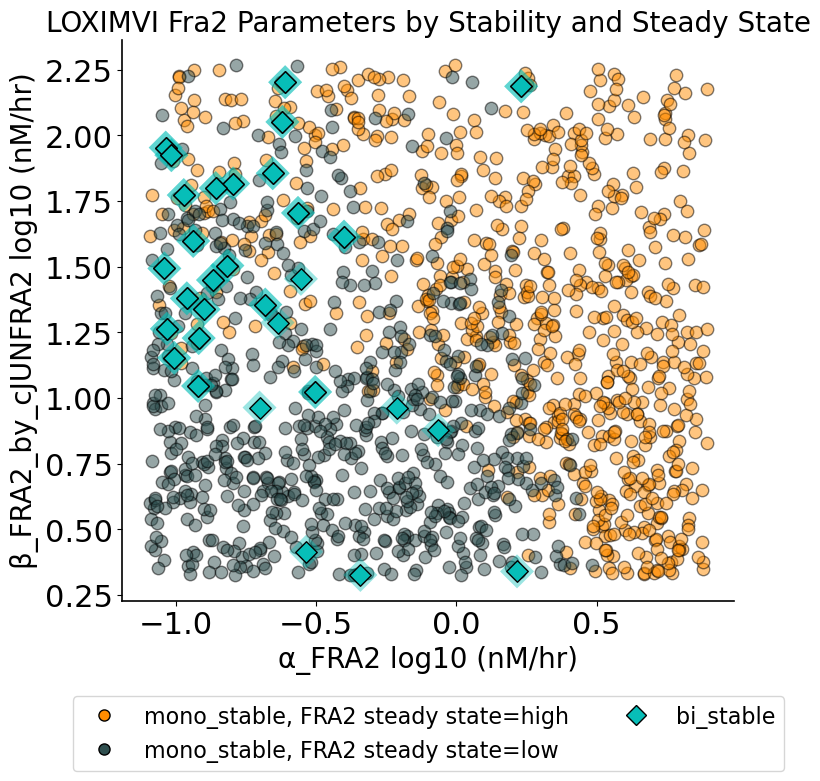

In [35]:
# Create figure 
plt.figure(figsize=(8, 8))

# Define markers and colors
markers = {'mono_stable': 'o', 'bi_stable': 'D'} 
colors = {'high': 'darkorange', 'low': 'darkslategray', 'bi_stable': '#07BEB8'}
sizes = {'mono_stable': 80, 'bi_stable': 120}  # Larger size for bistable points

# Plot mono_stable points
for fra2_state in ['high', 'low']:
    mask = (renamed_df['unique_steady_states'] == 'mono_stable') & (renamed_df['FRA2 steady state'] == fra2_state)
    subset = renamed_df[mask]
    
    plt.scatter(
        subset['log10_α_FRA2'], 
        subset['log10_β_FRA2_by_cJUNFRA2'],
        marker=markers['mono_stable'],
        c=colors[fra2_state],
        s=sizes['mono_stable'],
        edgecolors='black',
        alpha=0.5,
        label=f"mono_stable, FRA2 steady state={fra2_state}"
    )

# Plot all bi_stable points with glow effect
mask_bi = renamed_df['unique_steady_states'] == 'bi_stable'
bi_subset = renamed_df[mask_bi]

# First plot the glow
plt.scatter(
    bi_subset['log10_α_FRA2'], 
    bi_subset['log10_β_FRA2_by_cJUNFRA2'],
    marker=markers['bi_stable'],
    c='#07BEB8',  # Lighter skyblue for glow
    s=sizes['bi_stable'] * 2.5,  # Much larger for the glow
    alpha=0.4,  # Translucent for the glow effect
    edgecolors='none'  # No edge for the glow
)

# Then plot the actual points on top
plt.scatter(
    bi_subset['log10_α_FRA2'], 
    bi_subset['log10_β_FRA2_by_cJUNFRA2'],
    marker=markers['bi_stable'],
    c=colors['bi_stable'],
    s=sizes['bi_stable'],
    edgecolors='black',
    alpha=1,  # Higher alpha for the actual points
    label="bi_stable"
)

# Add labels and legend
plt.xlabel('α_FRA2 log10 (nM/hr)')
plt.ylabel('β_FRA2_by_cJUNFRA2 log10 (nM/hr)')
plt.title('LOXIMVI Fra2 Parameters by Stability and Steady State')
#plt.grid(True, alpha=0.3)

# Create a legend with custom handles
from matplotlib.lines import Line2D
custom_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', markeredgecolor='black', markersize=8, label='mono_stable, FRA2 steady state=high'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkslategray', markeredgecolor='black', markersize=8, label='mono_stable, FRA2 steady state=low'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='#07BEB8', markeredgecolor='black', markersize=10, label='bi_stable')
]

# Place legend at bottom
plt.legend(handles=custom_handles, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
# save as pdf
plt.savefig(f'Fig5E_multistable_LOXIMVI_analysis_alpha_beta_fra2.pdf', dpi=300)
plt.show()

### Figure 4 Heterogeneity analysis for monostable states
#### Question: What features in our parameter space separate the diffrences you observe within the monostable states?

In [34]:
# subset only mono_stable
mono_stable = dat[dat['unique_steady_states'] == 'mono_stable'].copy()
# drop init_cond_index column
mono_stable.drop('init_cond_index', axis=1, inplace=True)

# drop duplicate param_index
mono_stable.drop_duplicates(subset='param_index', inplace=True)

# drop param_index
mono_stable.drop('param_index', axis=1, inplace=True)
# drop unique_steady_states
mono_stable.drop('unique_steady_states', axis=1, inplace=True)
# remove the columns fos, jun, fra1, fra2, jund
mono_stable.drop(['fos', 'jun', 'fra1', 'fra2', 'jund','fos_ss','jun_ss','fra1_ss','fra2_ss','jund_ss'], axis=1, inplace=True)


In [45]:
dat

param_index  init_cond_index  (basal_fos).v  (basal_jun).v  \
0                  2              100       26.95602        0.50804   
1                  2               95       26.95602        0.50804   
2                  2               96       26.95602        0.50804   
3                  2               97       26.95602        0.50804   
4                  2               98       26.95602        0.50804   
...              ...              ...            ...            ...   
2272947        39997               50       55.57384        0.11293   
2272948        39997               51       55.57384        0.11293   
2272949        39997               52       55.57384        0.11293   
2272950        39997               53       55.57384        0.11293   
2272951        39997               47       55.57384        0.11293   

         (basal_fra1).v  (basal_fra2).v  (basal_jund).v  (jun_by_junjun).beta  \
0               0.20539         0.44878         5.35435              23.87186   
1               0.20539         0.44878         5.35435              23.87186   
2               0.20539         0.44878         5.35435              23.87186   
3               0.20539         0.44878         5.35435              23.87186   
4               0.20539         0.44878         5.35435              23.87186   
...                 ...             ...             ...                   ...   
2272947         3.22576         0.54404         4.82604             131.69051   
2272948         3.22576         0.54404         4.82604             131.69051   
2272949         3.22576         0.54404         4.82604             131.69051   
2272950         3.22576         0.54404         4.82604             131.69051   
2272951         3.22576         0.54404         4.82604             131.69051   

         (jun_by_junfos).beta  (fra1_by_junfra1).beta  ...      fra1     fra2  \
0                    34.50234                 3.95846  ...  45.47052  4.39770   
1                    34.50234                 3.95846  ...  33.56343  1.67222   
2                    34.50234                 3.95846  ...   1.60746  2.30712   
3                    34.50234                 3.95846  ...  25.50349  0.49166   
4                    34.50234                 3.95846  ...  12.45746  3.62302   
...                       ...                     ...  ...       ...      ...   
2272947              13.12777                 9.45439  ...   1.55621  0.62167   
2272948              13.12777                 9.45439  ...  19.67332  4.24453   
2272949              13.12777                 9.45439  ...   1.98982  0.74114   
2272950              13.12777                 9.45439  ...   2.39569  1.44661   
2272951              13.12777                 9.45439  ...  12.93960  4.86328   

              jund  unique_steady_states                   state  fos_ss  \
0         54.80465           mono_stable  high,low,high,low,high    46.7   
1         29.72116           mono_stable  high,low,high,low,high    46.7   
2         44.38918           mono_stable  high,low,high,low,high    46.7   
3         77.45921           mono_stable  high,low,high,low,high    46.7   
4         14.90250           mono_stable  high,low,high,low,high    46.7   
...            ...                   ...                     ...     ...   
2272947   72.04387           mono_stable  high,low,high,low,high    60.5   
2272948  119.80382           mono_stable  high,low,high,low,high    60.5   
2272949  128.18160           mono_stable  high,low,high,low,high    60.5   
2272950   17.40560           mono_stable  high,low,high,low,high    60.5   
2272951   19.40362           mono_stable  high,low,high,low,high    60.5   

         jun_ss  fra1_ss  fra2_ss  jund_ss  
0           1.0    107.5      1.9     17.8  
1           1.0    107.5      1.9     17.8  
2           1.0    107.5      1.9     17.8  
3           1.0    107.5      1.9     17.8  
4           1.0    107.5      1.9     17.8  
...         ...      ...   

In [47]:
# High FRA2 state should be class 1 for LOXIMVI
# High cFOS state should be class 1 for COLO858
# High FRA2 state should be class 1 for WM902B
interest_states = ['high,low,high,low,high']

mono_stable['interest_class'] = np.where(mono_stable['state'].isin(interest_states), 1, 0)

final_df = mono_stable.drop(columns = ['state'])

In [48]:
renamed_df = rename_columns(final_df.copy())

In [49]:
renamed_df


α_cFOS   α_cJUN   α_FRA1   α_FRA2   α_JUND  β_cJUN_by_cJUNcJUN  \
0        26.95602  0.50804  0.20539  0.44878  5.35435            23.87186   
150       7.15974  0.31774  0.16072  0.54048  4.26423             7.73887   
300      11.66137  0.42260  3.70721  0.32775  7.53577             4.41122   
450      15.55048  4.99971  0.70757  1.00437  5.11122           155.07185   
600      15.70035  0.32285  2.32457  1.63723  4.31938            65.28138   
...           ...      ...      ...      ...      ...                 ...   
2272202  20.20837  1.05627  0.71343  1.80778  5.45404             7.38354   
2272352  23.96882  1.76506  0.74736  2.06455  4.36644            11.96480   
2272502   5.84196  1.84934  0.47798  0.15982  5.77825            23.12290   
2272652  13.28676  4.62386  0.30056  0.68081  4.42421           127.97453   
2272802  55.57384  0.11293  3.22576  0.54404  4.82604           131.69051   

         β_cJUN_by_cJUNcFOS  β_FRA1_by_cJUNFRA1  β_FRA1_by_JUNDcFOS  \
0                  34.50234             3.95846            72.93446   
150                 4.17399            40.56476            60.97516   
300                 3.80039             2.26229            12.82114   
450                 3.10791             5.45237            17.34999   
600                22.53381            96.63559            58.03772   
...                     ...                 ...                 ...   
2272202             9.19275            12.23017             5.85757   
2272352            14.74865           185.84459            16.90029   
2272502             2.67421            73.05457            10.75602   
2272652             4.18890           103.41326             8.96498   
2272802            13.12777             9.45439             6.68439   

         β_FRA2_by_cJUNFRA2   γ_cFOS   γ_cJUN   γ_FRA1   γ_FRA2   γ_JUND  \
0                  87.29735  0.58739  0.56338  0.17690  0.25257  0.11311   
150               194.28917  0.48413  0.64775  0.38418  0.20111  0.19423   
300               142.24331  1.05475  0.67627  0.51045  0.28630  0.12478   
450                 4.04609  0.58534  0.85336  0.19216  0.09107  0.15842   
600                15.20315  0.46253  0.52475  0.54096  0.19259  0.10401   
...                     ...      ...      ...      ...      ...      ...   
2272202             4.12324  0.81596  1.19400  0.28715  0.27680  0.08184   
2272352             2.84839  1.02358  1.03512  0.47817  0.25328  0.12539   
2272502            84.12244  0.62978  1.04436  0.27691  0.12974  0.11386   
2272652             7.69569  0.59073  0.86583  0.55963  0.31349  0.11352   
2272802            66.32053  0.98946  0.66168  0.39312  0.13850  0.22622   

         interest_class  
0                     1  
150                   1  
300                   1  
450                   1  
600                   1  
...                 ...  
2272202               1  
2272352               1  
2272502               1  
2272652               1  
2272802               1  

[15477 rows x 16 columns]

/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ap1_proj/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: 

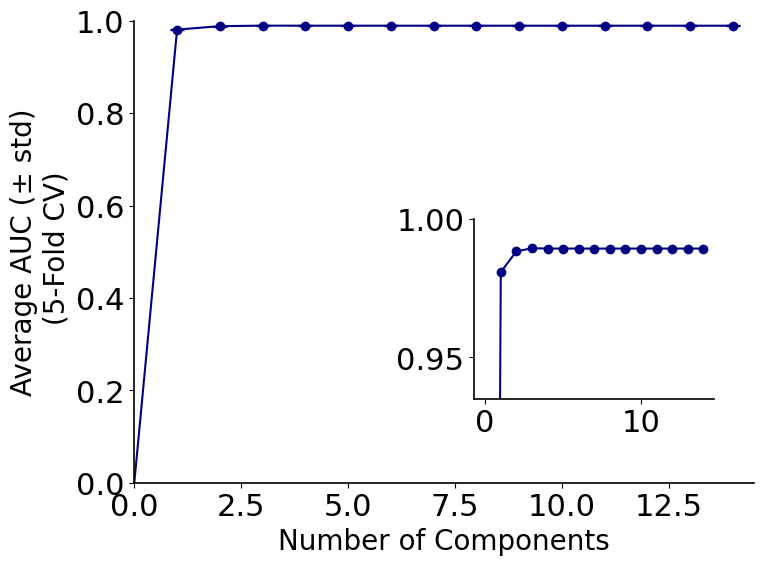

Maximum AUC at components: 3
Diminishing returns at components: 1
Maximum mean AUC: 0.989 ± 0.001
AUC at diminishing returns: 0.981 ± 0.002
Recommended number of components: 1
Optimal number of components: 1
Component 1:
Cumulative Y variance: 50.91%
Incremental Y variance: 50.91%


In [52]:
X = renamed_df.drop(columns = ['interest_class'])
y = renamed_df['interest_class']

# keep one hot encoding as False
plsda = PLSDA(n_components=None, cv_folds=5, one_hot_encode=False, downsample_ratio= 3)

# Determine the optimal number of components
optimal_components, mean_scores = plsda.find_optimal_components(X, y, max_components=14,save_plot=False)
print(f'Optimal number of components: {optimal_components}')

# Fit and transform the data using the optimal number of components
plsda.n_components = 1
X_pls, x_var,y_var, y_encoded, X_downsampled, y_balanced = plsda.fit_transform(X, y)

class_descriptions = {0: 'FRA1 low', 1: 'FRA1 high'}
# plot_scores = plsda.plot_scores_with_density(X_pls, x_var,y_var, y_encoded, lv1 = 0, lv2 = 1, class_descriptions=class_descriptions, 
#                                              colors = ['darkslategrey','darkorange'],
#                   alpha_values = [0.5, 0.9],line_colors = ['w','k'], save_plot=True)


In [ ]:
# y_scores, y_encoded = plsda.cross_validation(X, y)
# #plsda.plot_roc(y_scores, y_encoded)
# plsda.plot_mean_roc(X, y, save_plot=False)



In [ ]:
# vip_scores = plsda.compute_vip()
# signed_vip_scores, feature_names = plsda.compute_signed_vip(X,y,X.columns)
# # save figure as pdf

# plsda.plot_signed_vip(signed_vip_scores, feature_names, save_plot=True, colors=['darkslategrey','darkorange'])


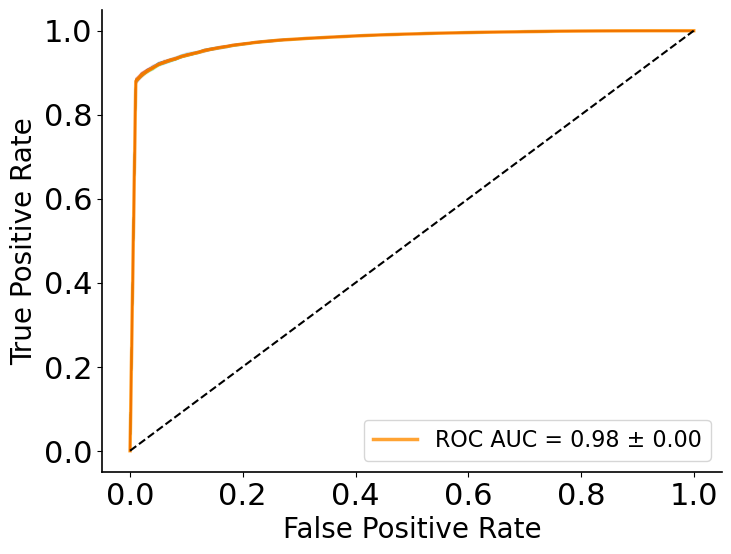

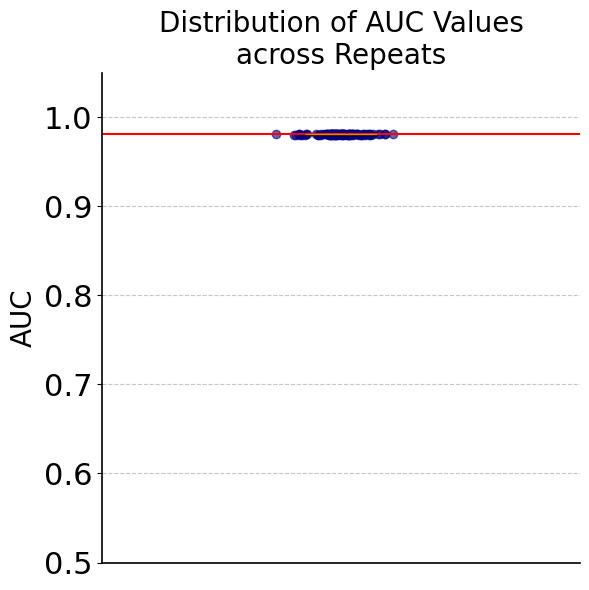

Repeated CV Results (100 repeats):
Mean AUC: 0.981 ± 0.000
Range: [0.980, 0.982]
Repeated cross-validation AUC: 0.981 ± 0.000


In [ ]:
mean_auc, std_auc = plsda.repeated_cv_with_visualization(
    X, y, n_repeats=1000, save_plot=True, show_individual_curves=True
)
print(f"Repeated cross-validation AUC: {mean_auc:.3f} ± {std_auc:.3f}")

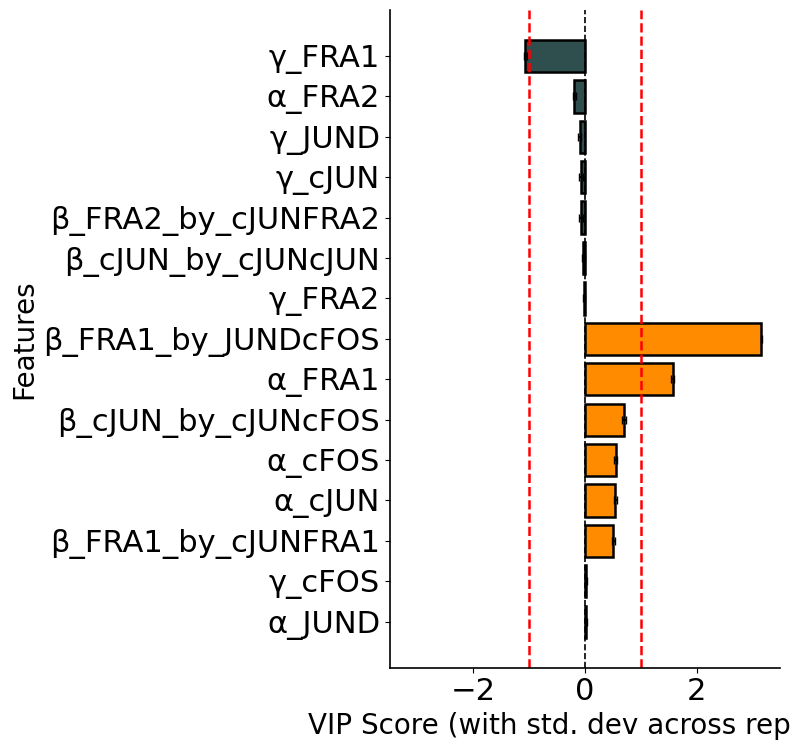

In [ ]:
mean_vips, std_vips, feature_names = plsda.plot_repeated_vip(
    X, y, n_repeats=1000, save_plot=True
)

#### Exploaratory analysis

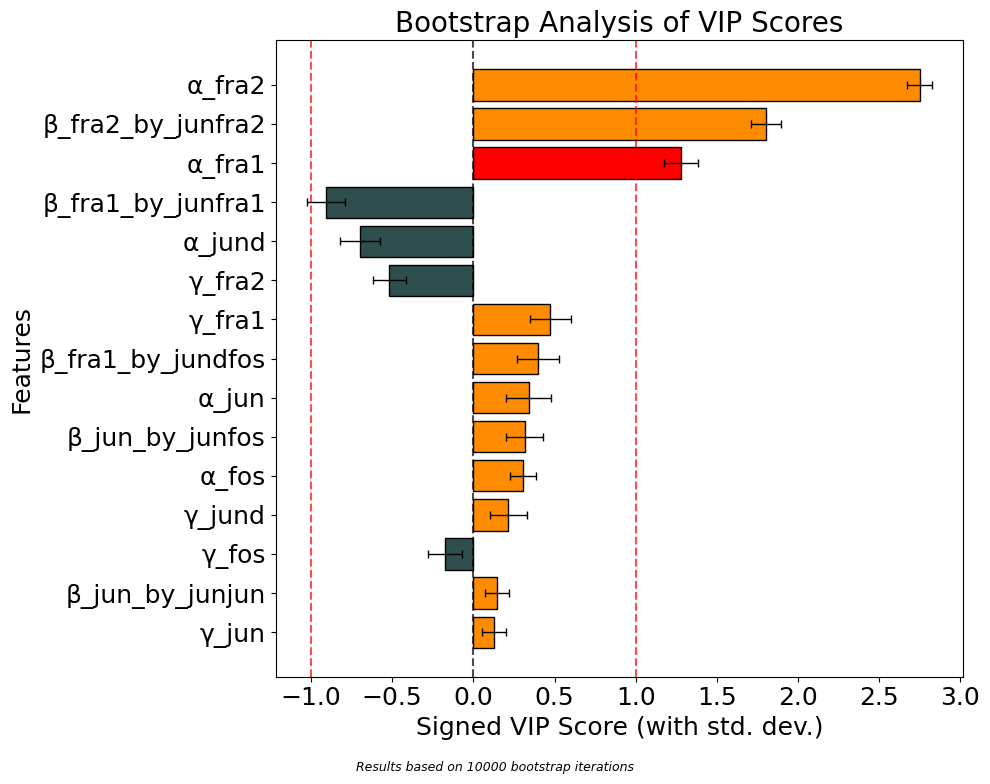

In [14]:
# Now run the bootstrap analysis
# Set number of bootstraps (more = better but slower)
n_bootstraps = 10000

# Run bootstrap analysis
bootstrap_results = plsda.bootstrap_vip_analysis(X, y, n_bootstraps=n_bootstraps, random_seed=42)

# Plot the results with your feature of interest highlighted
plsda.plot_bootstrap_vip(bootstrap_results, focus_feature='α_fra1', 
                        colors=['darkslategray', 'darkorange'], 
                        sort_by='absolute', save_plot=True)

In [16]:
renamed_df['interest_class'] = renamed_df['interest_class'].map({1: 'FRA2 high', 0: 'FRA2 low'})
renamed_df

α_fos    α_jun   α_fra1   α_fra2   α_jund  β_jun_by_junjun  \
0       3.51348  6.23938  2.75645  1.17920  5.03680         20.58021   
150     4.83183  5.65293  0.17113  2.54778  7.01086         58.12772   
300     0.69610  7.51703  0.17390  0.66903  2.47411          8.79305   
450     0.72296  6.10969  2.91160  1.25732  5.29329         28.86403   
600     8.60226  6.19385  0.17837  0.44547  4.28368          3.06599   
...         ...      ...      ...      ...      ...              ...   
192737  2.37300  6.35660  0.17751  1.83279  2.32691        192.29424   
192887  1.18747  7.88670  0.14613  0.36399  4.30143         18.62674   
192937  1.02638  6.21016  3.21132  2.35344  6.45143         67.53010   
193087  7.29294  0.14510  0.14453  1.54536  7.27952         21.59967   
193181  0.35969  7.43597  1.26553  0.30424  4.96410         11.85786   

        β_jun_by_junfos  β_fra1_by_junfra1  β_fra1_by_jundfos  \
0               5.81476           78.26636           21.73407   
150            31.97274           37.20289          102.96200   
300           169.28631           20.96384          143.84768   
450            37.24679           53.37406           20.63374   
600             4.38193          121.09712           47.92727   
...                 ...                ...                ...   
192737          3.42321          128.57895          110.00358   
192887        102.69864           73.89681            2.36649   
192937          3.29546           32.27748           77.10979   
193087        139.56446           10.31931           66.98887   
193181         76.53874           98.09277            8.79380   

        β_fra2_by_junfra2    γ_fos    γ_jun   γ_fra1   γ_fra2   γ_jund  \
0                17.17804  0.53332  0.73908  0.30491  0.10016  0.08571   
150              35.56151  1.53200  0.49401  0.31378  0.11460  0.13307   
300               2.97708  0.91342  0.76951  0.33246  0.08788  0.06786   
450              32.33980  0.51991  0.52255  0.54039  0.12717  0.14071   
600               6.25562  0.93905  0.57594  0.54014  0.09317  0.07512   
...                   ...      ...      ...      ...      ...      ...   
192737           26.59985  0.77317  1.15439  0.46146  0.20406  0.11004   
192887           42.23103  0.78702  0.85766  0.30010  0.11151  0.16108   
192937           44.00157  1.02830  1.11156  0.31652  0.11765  0.13490   
193087            4.13817  0.84657  0.54762  0.68252  0.30267  0.10912   
193181            3.29799  0.73360  0.51040  0.66733  0.10636  0.14381   

       interest_class  
0           FRA2 high  
150         FRA2 high  
300          FRA2 low  
450         FRA2 high  
600          FRA2 low  
...               ...  
192737      FRA2 high  
192887       FRA2 low  
192937      FRA2 high  
193087       FRA2 low  
193181       FRA2 low  

[1366 rows x 16 columns]

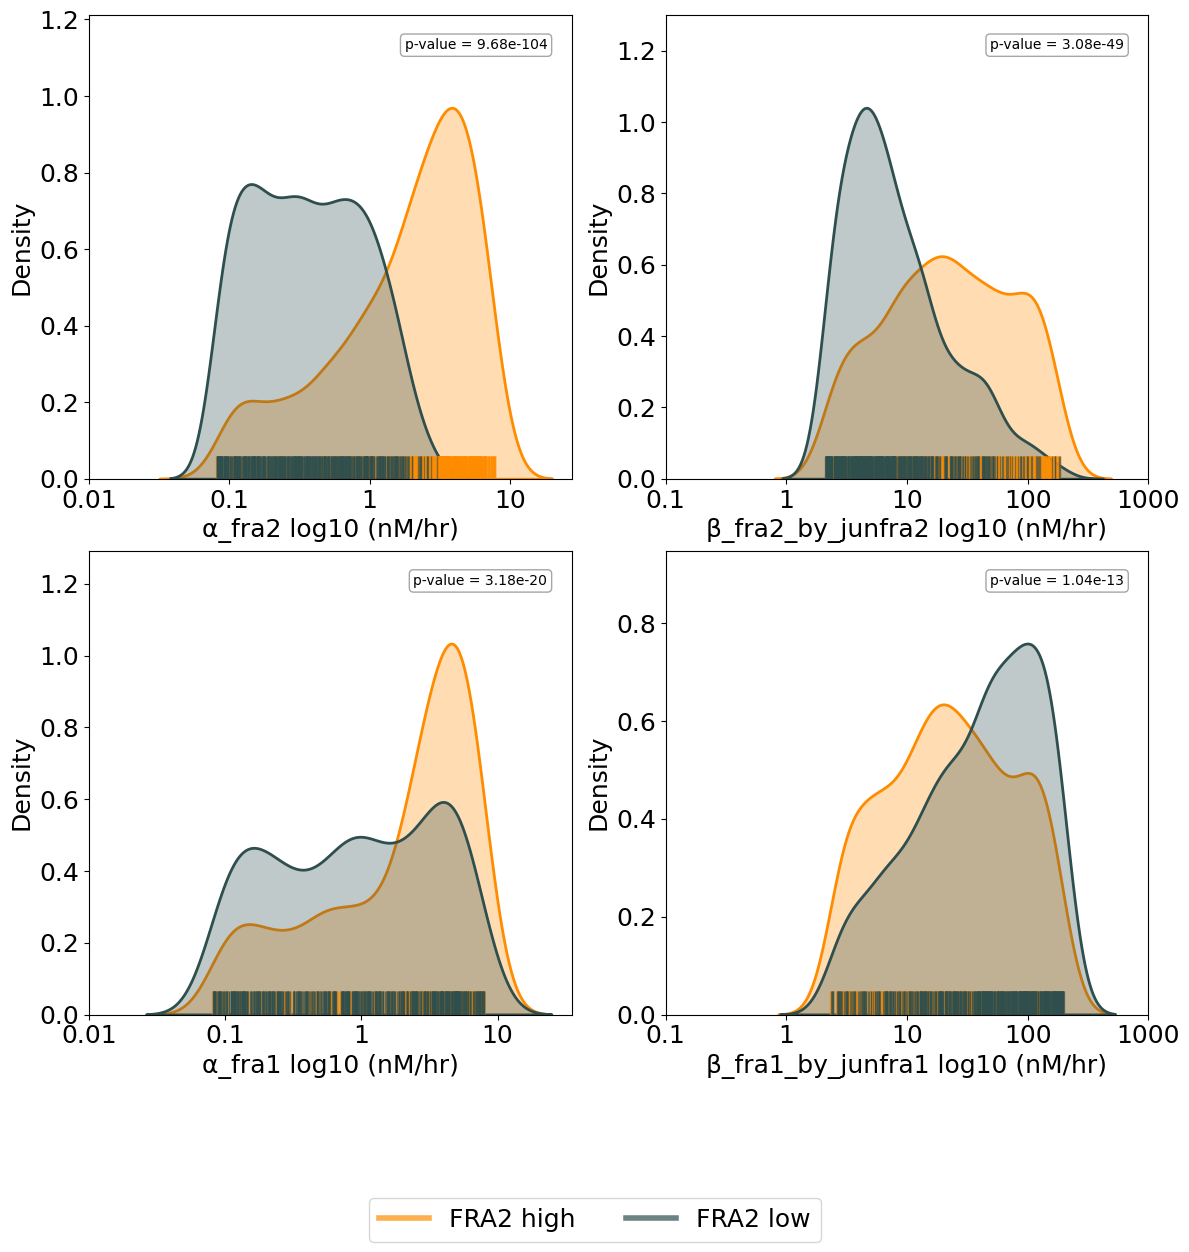

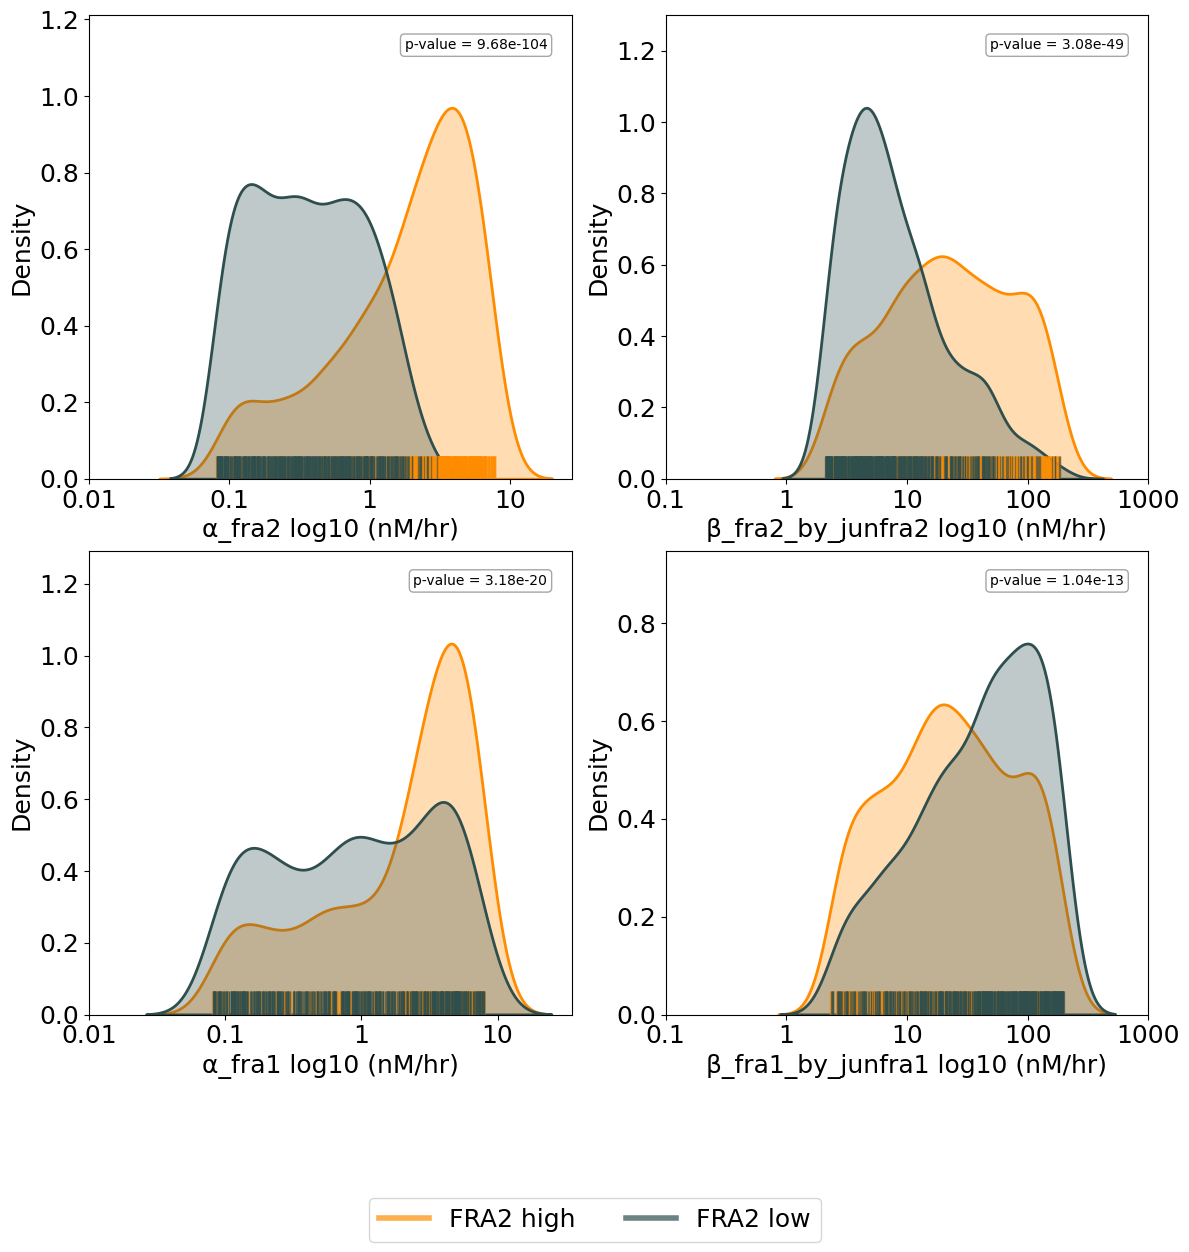

In [89]:
# plot distribution of fra2 for the high and low fra2 states

par_names = ['α_fra2', 'β_fra2_by_junfra2', 'α_fra1','β_fra1_by_junfra1']
plot_ap1.plot_parameter_distributions(renamed_df, par_names, 'interest_class', 
                                      color_palette={'FRA2 low': 'darkslategrey', 'FRA2 high': 'darkorange'}, 
                                      ncols=2, figsize=(12,12), stat_test='mann_whitney',
                                     output_filename=f'monostable_{cell}_distribution.pdf')

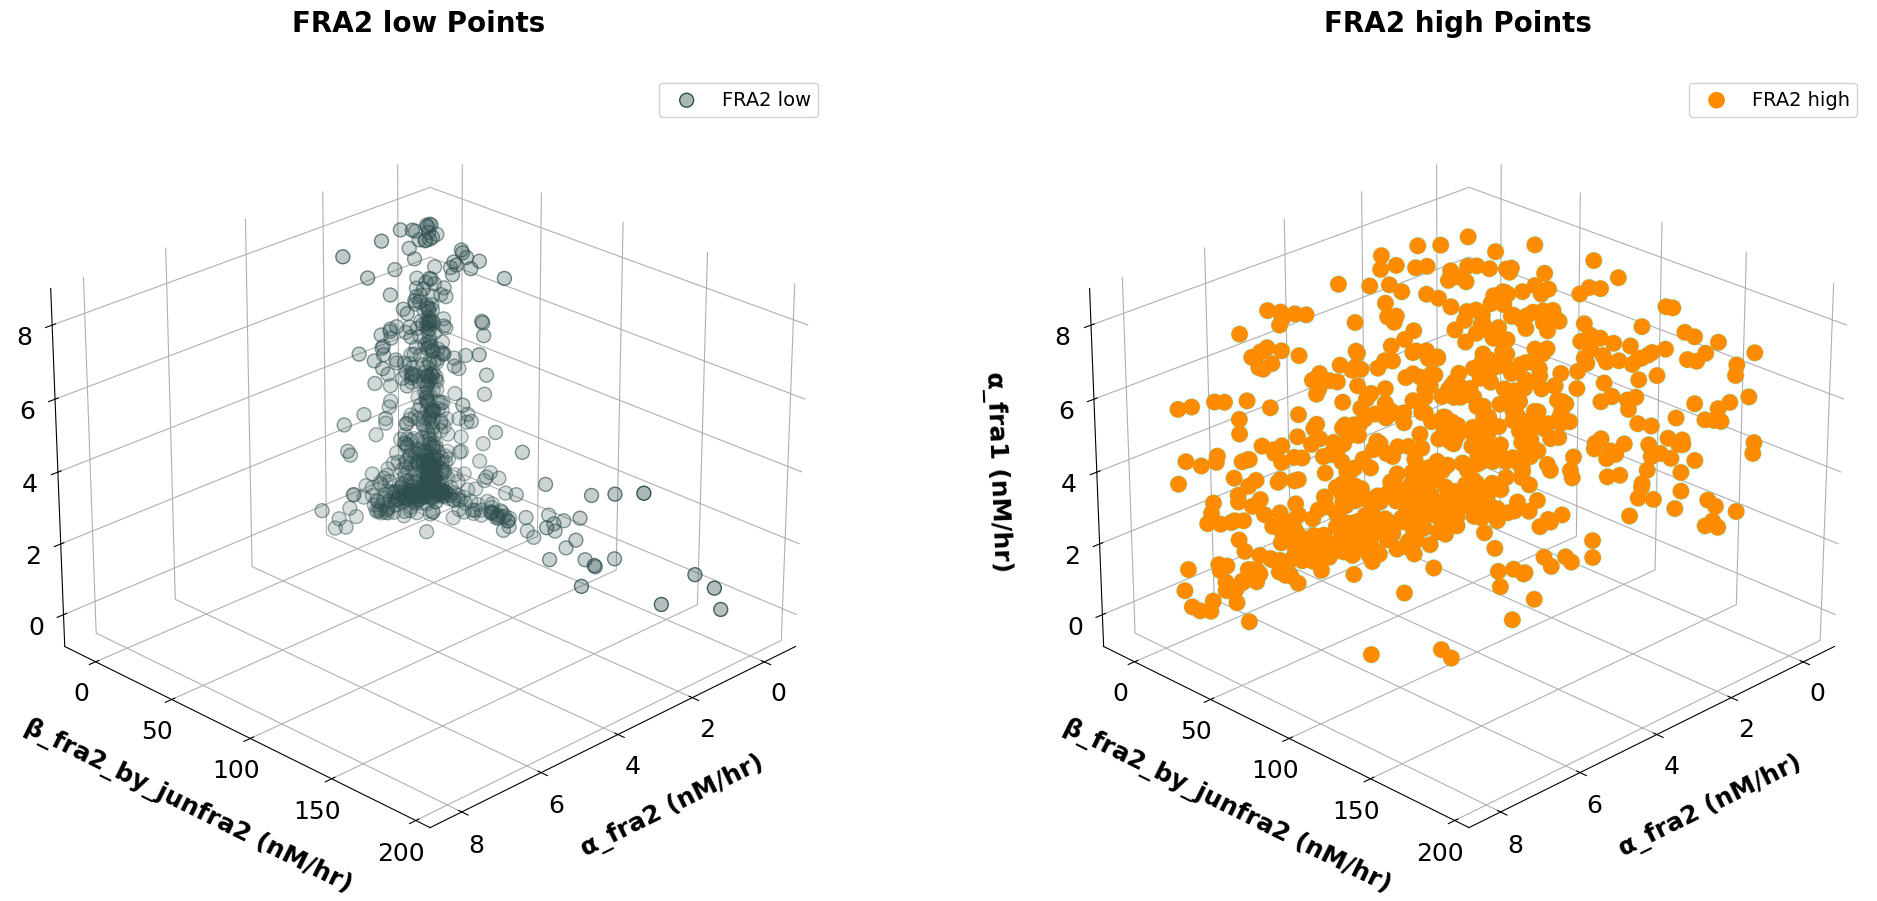

In [43]:
fig, ax = plot_3d_scatter_subplots(
    renamed_df, 
    'α_fra2','β_fra2_by_junfra2','α_fra1',
    class0='FRA2 low',
    class1='FRA2 high',
    color_map={'FRA2 low': 'darkslategrey', 'FRA2 high': 'darkorange'},
    opacity_map={'FRA2 low': 0.4, 'FRA2 high': 1.0},
    size_map={'FRA2 low': 10, 'FRA2 high': 10},
    edge_color_map={'FRA2 low': 'darkslategrey','FRA2 high': 'darkorange'},
    output_filename=f'monostable_{cell}_3d_scatter_FRA2.pdf'
)

In [17]:
renamed_df

α_fos    α_jun   α_fra1   α_fra2   α_jund  β_jun_by_junjun  \
0       3.51348  6.23938  2.75645  1.17920  5.03680         20.58021   
150     4.83183  5.65293  0.17113  2.54778  7.01086         58.12772   
300     0.69610  7.51703  0.17390  0.66903  2.47411          8.79305   
450     0.72296  6.10969  2.91160  1.25732  5.29329         28.86403   
600     8.60226  6.19385  0.17837  0.44547  4.28368          3.06599   
...         ...      ...      ...      ...      ...              ...   
192737  2.37300  6.35660  0.17751  1.83279  2.32691        192.29424   
192887  1.18747  7.88670  0.14613  0.36399  4.30143         18.62674   
192937  1.02638  6.21016  3.21132  2.35344  6.45143         67.53010   
193087  7.29294  0.14510  0.14453  1.54536  7.27952         21.59967   
193181  0.35969  7.43597  1.26553  0.30424  4.96410         11.85786   

        β_jun_by_junfos  β_fra1_by_junfra1  β_fra1_by_jundfos  \
0               5.81476           78.26636           21.73407   
150            31.97274           37.20289          102.96200   
300           169.28631           20.96384          143.84768   
450            37.24679           53.37406           20.63374   
600             4.38193          121.09712           47.92727   
...                 ...                ...                ...   
192737          3.42321          128.57895          110.00358   
192887        102.69864           73.89681            2.36649   
192937          3.29546           32.27748           77.10979   
193087        139.56446           10.31931           66.98887   
193181         76.53874           98.09277            8.79380   

        β_fra2_by_junfra2    γ_fos    γ_jun   γ_fra1   γ_fra2   γ_jund  \
0                17.17804  0.53332  0.73908  0.30491  0.10016  0.08571   
150              35.56151  1.53200  0.49401  0.31378  0.11460  0.13307   
300               2.97708  0.91342  0.76951  0.33246  0.08788  0.06786   
450              32.33980  0.51991  0.52255  0.54039  0.12717  0.14071   
600               6.25562  0.93905  0.57594  0.54014  0.09317  0.07512   
...                   ...      ...      ...      ...      ...      ...   
192737           26.59985  0.77317  1.15439  0.46146  0.20406  0.11004   
192887           42.23103  0.78702  0.85766  0.30010  0.11151  0.16108   
192937           44.00157  1.02830  1.11156  0.31652  0.11765  0.13490   
193087            4.13817  0.84657  0.54762  0.68252  0.30267  0.10912   
193181            3.29799  0.73360  0.51040  0.66733  0.10636  0.14381   

       interest_class  
0           FRA2 high  
150         FRA2 high  
300          FRA2 low  
450         FRA2 high  
600          FRA2 low  
...               ...  
192737      FRA2 high  
192887       FRA2 low  
192937      FRA2 high  
193087       FRA2 low  
193181       FRA2 low  

[1366 rows x 16 columns]

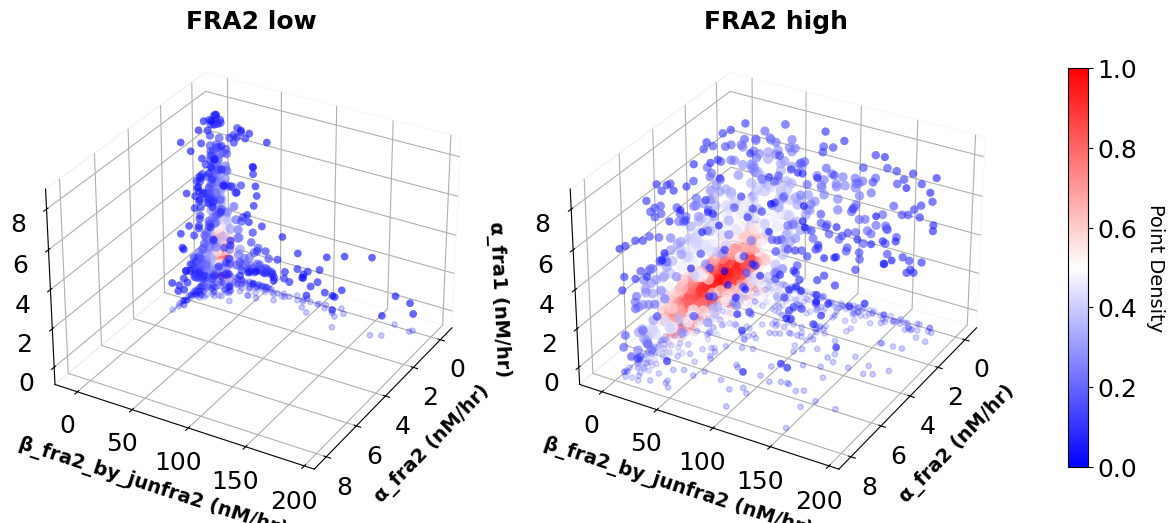

In [20]:
fig_3d = plot_3d_density(
    renamed_df,
    'α_fra2', 
    'β_fra2_by_junfra2', 
    'α_fra1',
    x_unit='nM/hr',
    y_unit='nM/hr', 
    z_unit='nM/hr',
    interest_class_column='interest_class',
    class0='FRA2 low',
    class1='FRA2 high',
    output_filename=f'monostable_{cell}_3d_density'
)

/Volumes/FallahiLab/Maize-Data/Data/Yonatan_Degefu/AP1_mechanistic_modelling/plot_ap1.py:726: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar


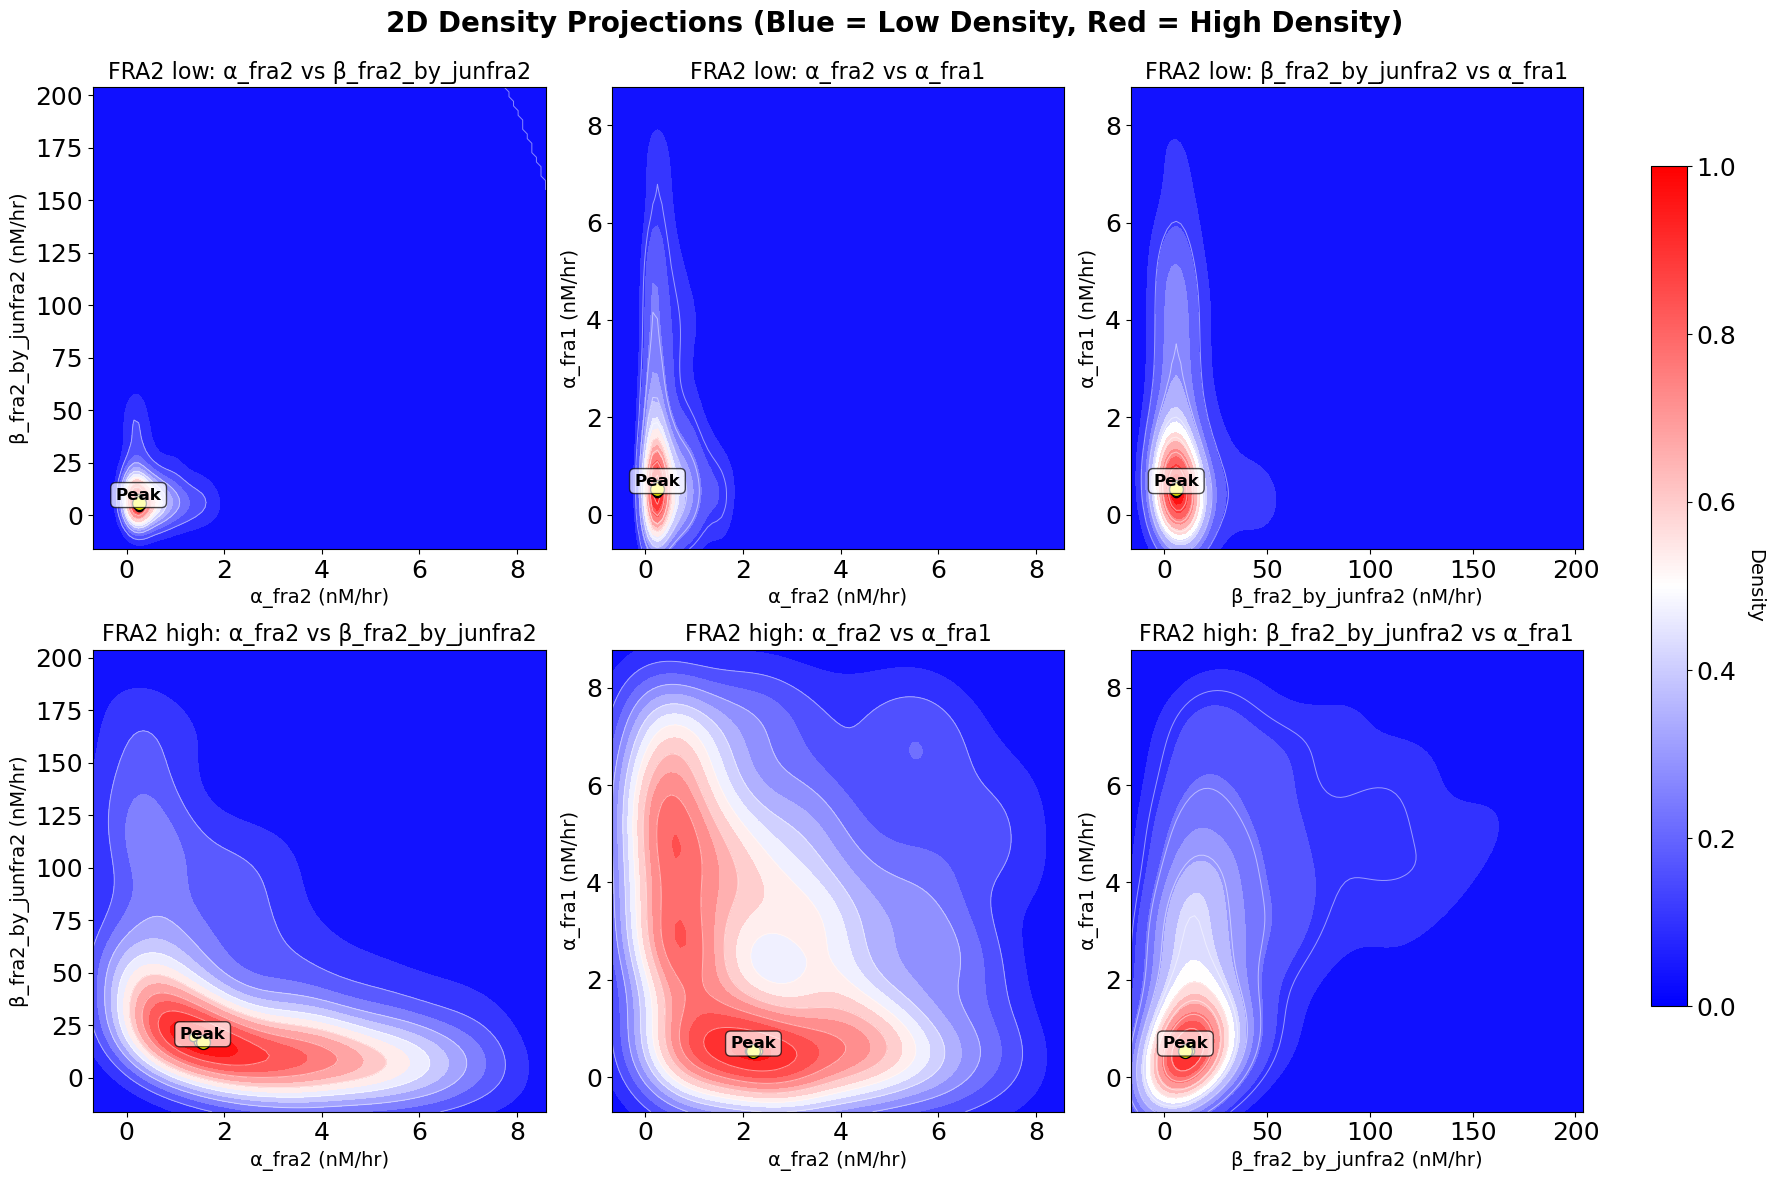

In [21]:
fig_2d = plot_2d_density_projections(
    renamed_df,
    'α_fra2', 
    'β_fra2_by_junfra2', 
    'α_fra1',
    x_unit='nM/hr',
    y_unit='nM/hr', 
    z_unit='nM/hr',
    interest_class_column='interest_class',
    class0='FRA2 low',
    class1='FRA2 high',
    output_filename=f'monostable_{cell}_2d_density_projections'
)

### Heterogeneity analysis for Bistable states
#### Question: What features in our initial condition space separate the diffrences you observe within the bistable states?

In [18]:
bi_stable = dat[dat['unique_steady_states'] == 'bi_stable'].copy()
cols_to_keep = ['param_index', 'fos', 'jun', 'fra1', 'fra2', 'jund','state']
bi_stable = bi_stable[cols_to_keep]
bi_stable

param_index      fos       jun       fra1      fra2       jund  \
4382            885  3.57658  43.48596  312.36820  28.78495   37.08268   
4383            885  1.52699  46.05060   21.14838  12.32903   20.52553   
4384            885  0.76106  45.01576   18.20320   3.52857  173.79531   
4385            885  1.08145  28.61489  115.89245  92.34483  161.67069   
4386            885  0.65172  30.80307   14.92481   2.53974   93.82532   
...             ...      ...       ...        ...       ...        ...   
190614        39559  0.65172  30.80307   14.92481   2.53974   93.82532   
190615        39559  1.08145  28.61489  115.89245  92.34483  161.67069   
190616        39559  0.76106  45.01576   18.20320   3.52857  173.79531   
190617        39559  1.52699  46.05060   21.14838  12.32903   20.52553   
190618        39559  2.88480  18.81182   50.58687  37.83377   13.52518   

                          state  
4382    low,high,high,high,high  
4383    low,high,high,high,high  
4384    low,high,high,high,high  
4385    low,high,high,high,high  
4386    low,high,high,high,high  
...                         ...  
190614  low,high,high,high,high  
190615  low,high,high,high,high  
190616  low,high,high,high,high  
190617  low,high,high,high,high  
190618  low,high,high,high,high  

[4174 rows x 7 columns]

In [19]:
bi_stable = dat[dat['unique_steady_states'] == 'bi_stable'].copy()
cols_to_keep = ['param_index', 'fos', 'jun', 'fra1', 'fra2', 'jund','state']
bi_stable = bi_stable[cols_to_keep]
# param_value = 5153

# keep only the rows where param_index is equal to param_value
#bi_stable = bi_stable[bi_stable['param_index'] == param_value]

# remove param_index
bi_stable.drop('param_index', axis=1, inplace=True)
interest_states = ['low,high,high,high,high']

bi_stable['interest_class'] = np.where(bi_stable['state'].isin(interest_states), 1, 0)
# drop the state column
bi_stable.drop('state', axis=1, inplace=True)

# # add a column that is a ratio of fra2 and jund
# #bi_stable['fra2/jund'] = bi_stable['fra2'] / bi_stable['jund']

bi_stable


fos       jun       fra1      fra2       jund  interest_class
4382    3.57658  43.48596  312.36820  28.78495   37.08268               1
4383    1.52699  46.05060   21.14838  12.32903   20.52553               1
4384    0.76106  45.01576   18.20320   3.52857  173.79531               1
4385    1.08145  28.61489  115.89245  92.34483  161.67069               1
4386    0.65172  30.80307   14.92481   2.53974   93.82532               1
...         ...       ...        ...       ...        ...             ...
190614  0.65172  30.80307   14.92481   2.53974   93.82532               1
190615  1.08145  28.61489  115.89245  92.34483  161.67069               1
190616  0.76106  45.01576   18.20320   3.52857  173.79531               1
190617  1.52699  46.05060   21.14838  12.32903   20.52553               1
190618  2.88480  18.81182   50.58687  37.83377   13.52518               1

[4174 rows x 6 columns]

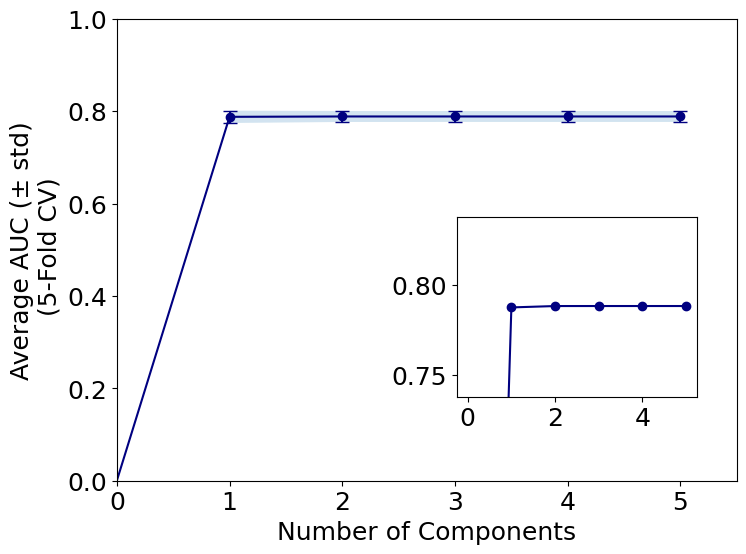

Maximum AUC at components: 4
Diminishing returns at components: 1
Maximum mean AUC: 0.788 ± 0.012
AUC at diminishing returns: 0.788 ± 0.013
Recommended number of components: 1
Optimal number of components: 1
Component 1:
Cumulative Y variance: 24.44%
Incremental Y variance: 24.44%
Component 2:
Cumulative Y variance: 24.70%
Incremental Y variance: 0.26%


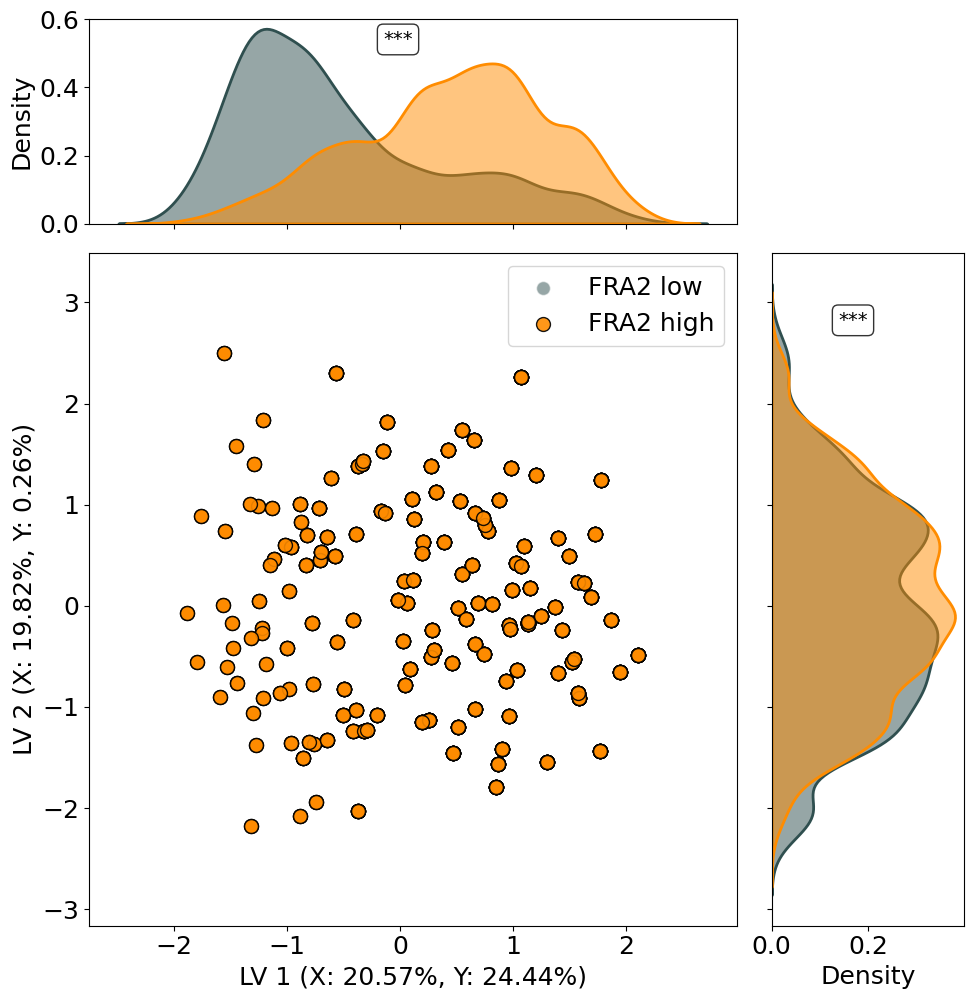

In [20]:
X = bi_stable.drop(columns = ['interest_class'])
y = bi_stable['interest_class']

# keep one hot encoding as False
plsda = PLSDA(n_components=None, cv_folds=5, one_hot_encode=False, cv_method = 'kfold')

# Determine the optimal number of components
optimal_components, mean_scores = plsda.find_optimal_components(X, y, max_components=5)
print(f'Optimal number of components: {optimal_components}')

## Fit and transform the data using the optimal number of components
plsda.n_components = 2
X_pls, x_var,y_var, y_encoded, X_downsampled, y_balanced = plsda.fit_transform(X, y)

class_descriptions = {0: 'FRA2 low', 1: 'FRA2 high'}
plot_scores = plsda.plot_scores_with_density(X_pls, x_var,y_var, y_encoded, lv1 = 0, lv2 = 1, class_descriptions=class_descriptions, 
                                             colors = ['darkslategrey','darkorange'],
                  alpha_values = [0.5, 0.9],line_colors = ['w','k'], save_plot=False)

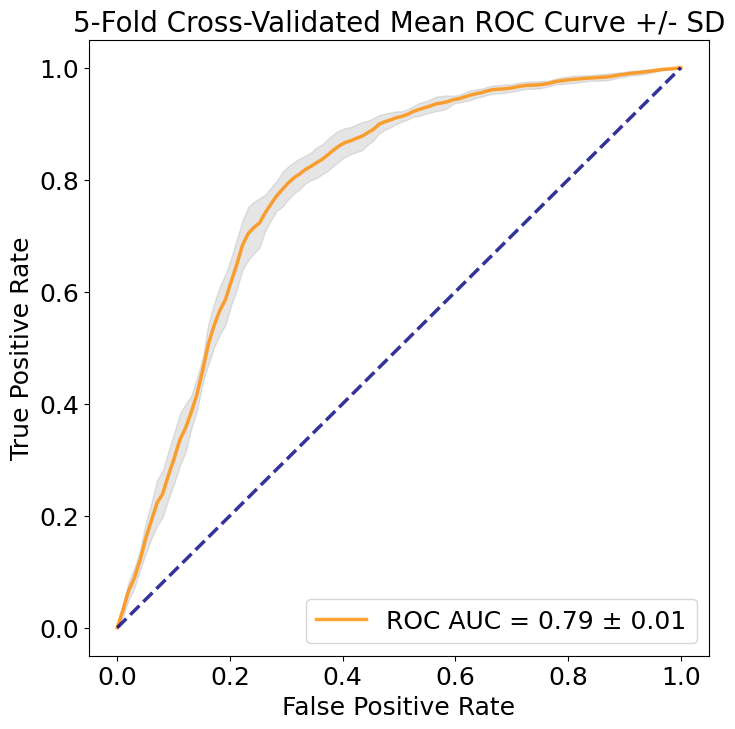

AUC of mean ROC: 0.79
Average of individual AUCs: 0.79 ± 0.01


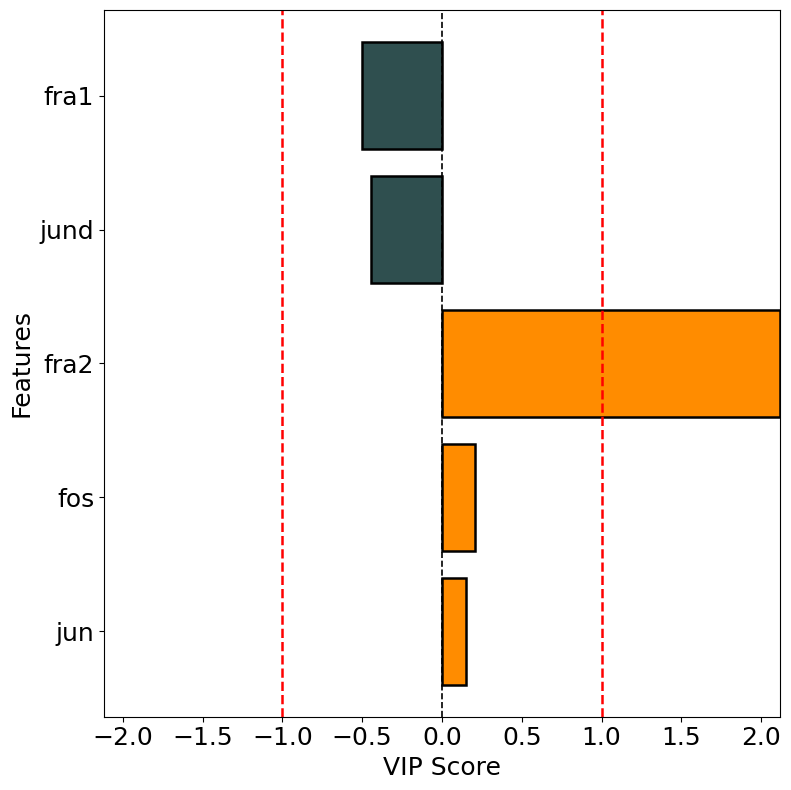

In [21]:
y_scores, y_encoded = plsda.cross_validation(X, y)
#plsda.plot_roc(y_scores, y_encoded)
plsda.plot_mean_roc(X, y, save_plot=False)

vip_scores = plsda.compute_vip()
signed_vip_scores, feature_names = plsda.compute_signed_vip(X,y,X.columns)
# save figure as pdf

plsda.plot_signed_vip(signed_vip_scores, feature_names, save_plot=False, colors=['darkslategrey','darkorange'])


In [ ]:
# Get VIP and loading scores
vip_scores = plsda.compute_vip()
signed_vip_scores, feature_names = plsda.compute_signed_vip(X,y,X.columns)
plsda.plot_signed_vip(signed_vip_scores, feature_names)

#### Running multiple PLSDA models for each parameter index to see which proteins have high VIP scores VIP > 1

In [ ]:
# Prepare the data
bi_stable = dat[dat['unique_steady_states'] == 'bi_stable'].copy()
cols_to_keep = ['param_index', 'fos', 'jun', 'fra1', 'fra2', 'jund', 'state']
bi_stable = bi_stable[cols_to_keep]

interest_states = ['low,high,high,high,high']

# Initialize lists to store results
auc_scores = []
vip_scores_list = []
param_indexes = bi_stable['param_index'].unique()

for param_value in param_indexes:
    # Subset data for current param_index
    subset = bi_stable[bi_stable['param_index'] == param_value].copy()
    subset.drop('param_index', axis=1, inplace=True)
    
    # Create target variable
    subset['interest_class'] = np.where(subset['state'].isin(interest_states), 1, 0)
    subset.drop('state', axis=1, inplace=True)
    
    X = subset.drop(columns=['interest_class'])
    y = subset['interest_class']
    
    # Initialize PLSDA model
    plsda = PLSDA(n_components=None, cv_folds=3, one_hot_encode=False, cv_method='kfold')
    
    # Find optimal number of components
    optimal_components, mean_scores = plsda.find_optimal_components(X, y, max_components=5, show_plot=False)
    print(f'Param index {param_value} - Optimal number of components: {optimal_components}')
    
    # Fit and transform the data using the optimal number of components
    plsda.n_components = optimal_components
    X_pls, x_var,y_var, y_encoded, X_downsampled, y_balanced = plsda.fit_transform(X, y)
    
    # Calculate mean AUC
    mean_auc = plsda.plot_mean_roc(X, y, show_plot=False)
    auc_scores.append((param_value, mean_auc))
    
    # Compute VIP scores
    vip_scores = plsda.compute_vip()
    vip_scores_list.append((param_value, vip_scores))

# Create DataFrame with results
auc_df = pd.DataFrame(auc_scores, columns=['param_index', 'AUC'])
vip_df = pd.DataFrame(vip_scores_list, columns=['param_index', 'VIP_scores'])

# Merge AUC and VIP scores
results_df = pd.merge(auc_df, vip_df, on='param_index')

protein_names = ['fos', 'jun', 'fra1', 'fra2', 'jund']
for i, protein in enumerate(protein_names):
    results_df[f'VIP_{protein}'] = results_df['VIP_scores'].apply(lambda x: x[i])

results_df.drop('VIP_scores', axis=1, inplace=True)

results_df

In [31]:
# remove param_index with AUC < 0.6
results_df = results_df[results_df['AUC'] > 0.6]
# multiply VIPfra1 and VIPjund by -1
results_df['VIP_fra1'] = results_df['VIP_fra1'] * -1
results_df['VIP_jund'] = results_df['VIP_jund'] * -1

/var/folders/__/h1scybwx6txcjzlhvr2q1wwm0000gn/T/ipykernel_2652/2311992091.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['VIP_fra1'] = results_df['VIP_fra1'] * -1
/var/folders/__/h1scybwx6txcjzlhvr2q1wwm0000gn/T/ipykernel_2652/2311992091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['VIP_jund'] = results_df['VIP_jund'] * -1


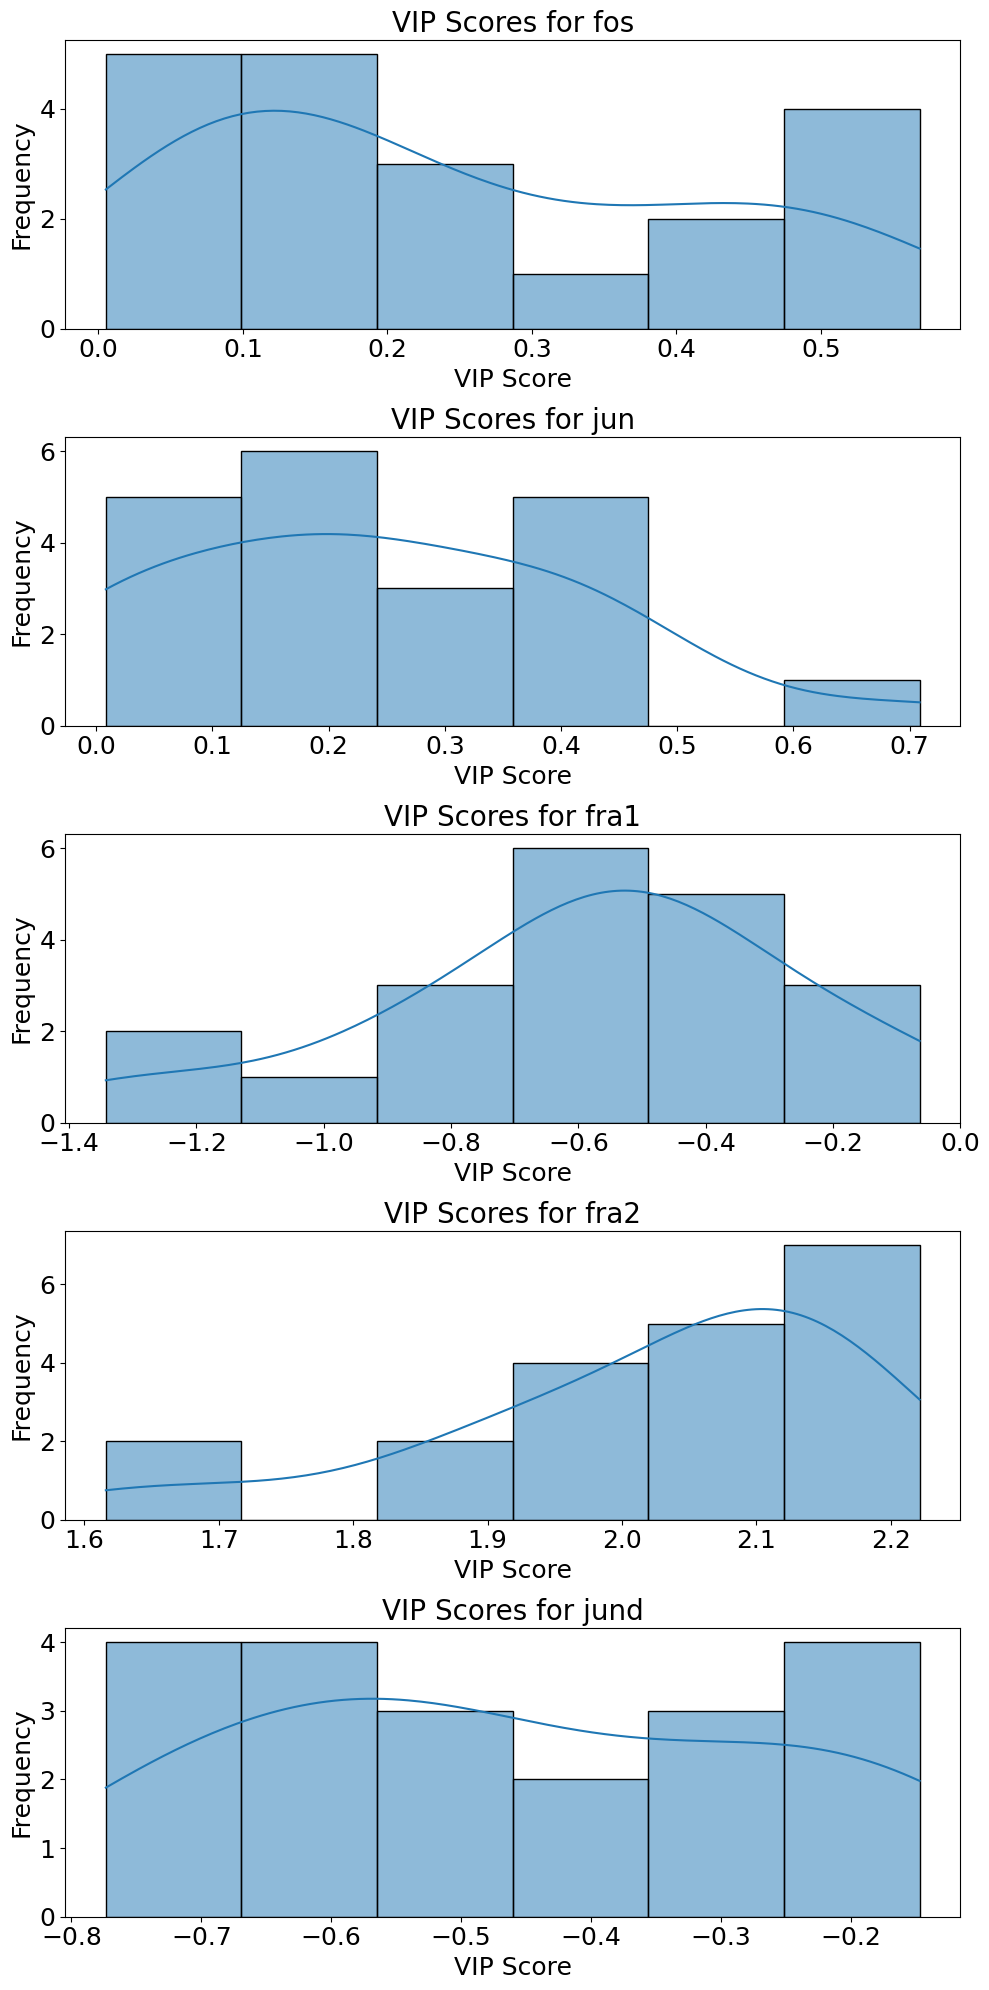

In [32]:
# plot a histogram of the VIP scores for each protein as a subplot with 1 column and 5 rows
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

for i, protein in enumerate(protein_names):
    sns.histplot(results_df[f'VIP_{protein}'], kde=True, ax=axes[i])
    axes[i].set_title(f'VIP Scores for {protein}')
    axes[i].set_xlabel('VIP Score')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
    

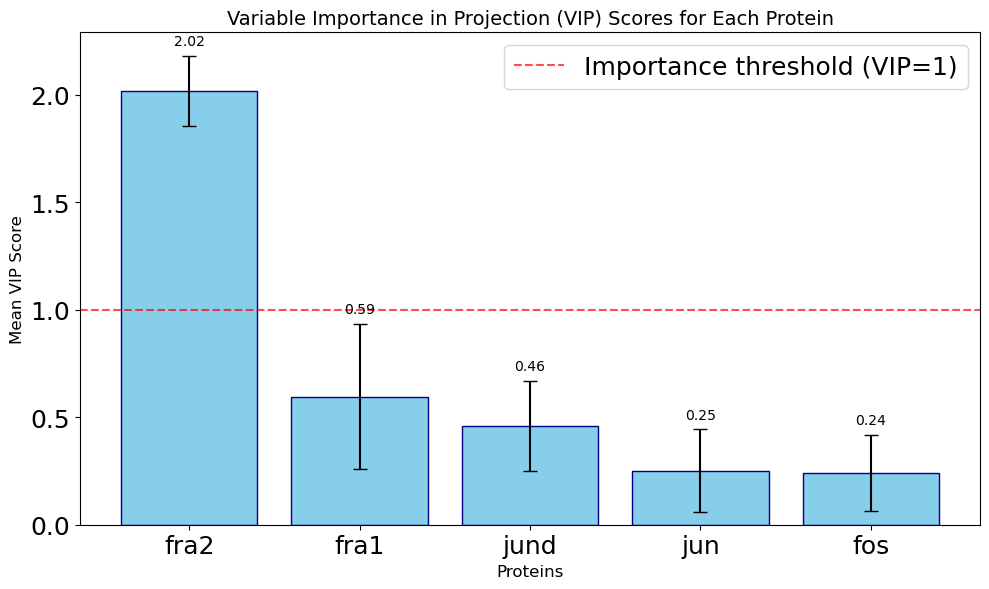

In [10]:
# Calculate mean and standard deviation of VIP scores for each protein
vip_means = {}
vip_stds = {}

for protein in ['fos', 'jun', 'fra1', 'fra2', 'jund']:
    vip_scores = results_df[f'VIP_{protein}']
    vip_means[protein] = vip_scores.mean()
    vip_stds[protein] = vip_scores.std()

# Sort proteins by mean VIP score for better visualization
sorted_proteins = sorted(vip_means.keys(), key=lambda x: vip_means[x], reverse=True)

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_proteins, 
        [vip_means[p] for p in sorted_proteins], 
        yerr=[vip_stds[p] for p in sorted_proteins],
        capsize=5,
        color='skyblue',
        edgecolor='navy')

# Add labels and title
plt.xlabel('Proteins', fontsize=12)
plt.ylabel('Mean VIP Score', fontsize=12)
plt.title('Variable Importance in Projection (VIP) Scores for Each Protein', fontsize=14)

# Add value labels on top of each bar
for i, protein in enumerate(sorted_proteins):
    plt.text(i, vip_means[protein] + vip_stds[protein] + 0.05, 
             f'{vip_means[protein]:.2f}', 
             ha='center', fontsize=10)

# Add a horizontal line at VIP = 1 (common threshold for importance)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Importance threshold (VIP=1)')

plt.legend()
plt.tight_layout() 

plt.show()

/var/folders/__/h1scybwx6txcjzlhvr2q1wwm0000gn/T/ipykernel_2652/3297501095.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


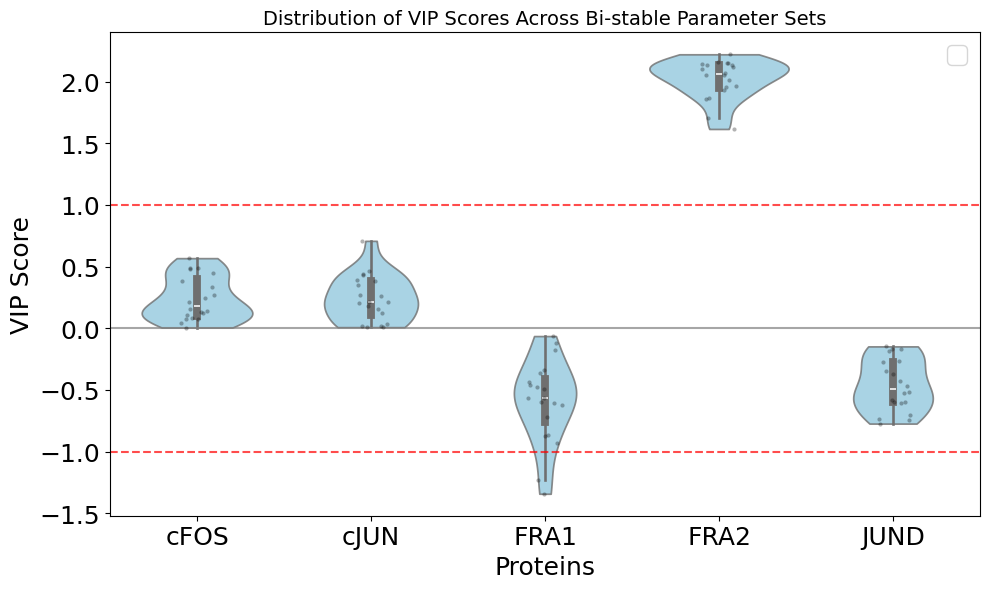

In [37]:
# Reshape data for seaborn
vip_data = []
for protein in ['fos', 'jun', 'fra1', 'fra2', 'jund']:
    for score in results_df[f'VIP_{protein}']:
        vip_data.append({'Protein': protein, 'VIP Score': score})

vip_df = pd.DataFrame(vip_data)

# Create the plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='Protein', 
    y='VIP Score', 
    data=vip_df, 
    color='skyblue',
    alpha = 0.8,
    inner='box',  # Shows box plot inside violin
    cut=0         # Limit the violin range to the observed data
)

# Add individual data points
sns.stripplot(
    x='Protein', 
    y='VIP Score', 
    data=vip_df, 
    color='black', 
    alpha=0.3,
    jitter=True,
    size=3
)
# reanme x labels to cFOS, cJUN, FRA1, FRA2, JUND 
# Rename x-axis labels
plt.xticks(range(5), ['cFOS', 'cJUN', 'FRA1', 'FRA2', 'JUND'])


# Add horizontal line at VIP = 1
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=-1, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='grey', linestyle='-', alpha=0.7)

plt.xlabel('Proteins')
plt.ylabel('VIP Score')
plt.title('Distribution of VIP Scores Across Bi-stable Parameter Sets', fontsize=14)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
# 
plt.savefig('Fig5Supp_bistable_25_parmas_vip_scores_violin.pdf', format='pdf', bbox_inches='tight', dpi=300)


plt.show()